# Gym Test Environment

In [1]:
# The typical imports
import gym
from gym.wrappers import Monitor
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

import keras
from keras import backend as K
from keras.layers.merge import multiply
import itertools
from tqdm import tqdm_notebook as tqdm
import glob
import re


/home/fabi/anaconda3/envs/gym/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))


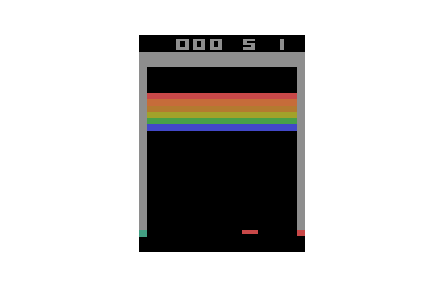
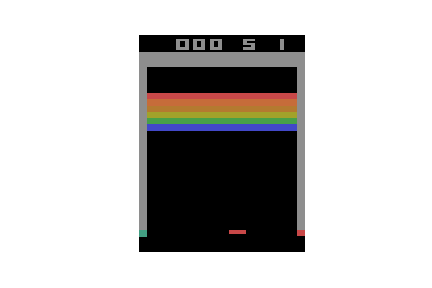
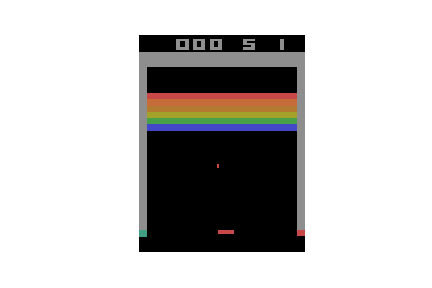
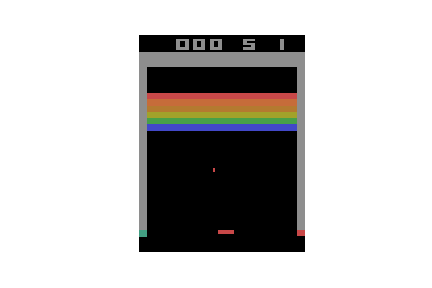
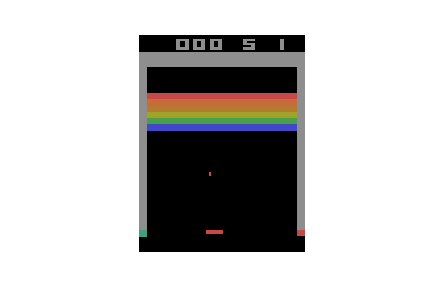
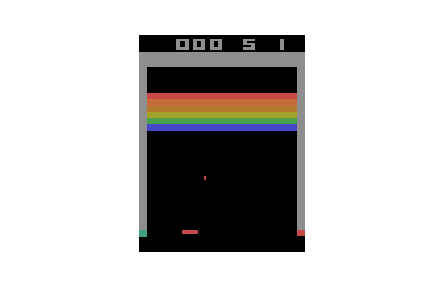
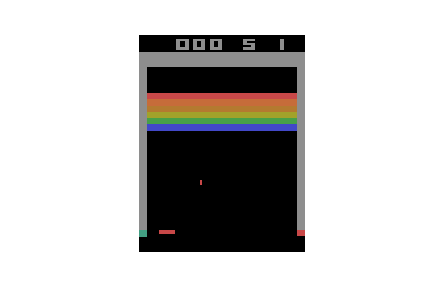
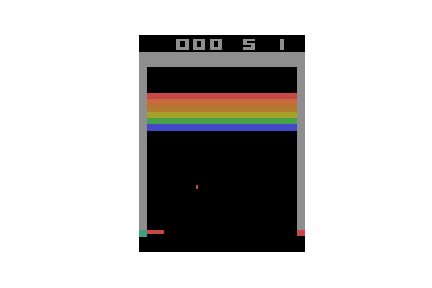
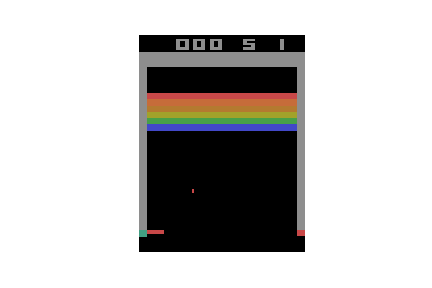
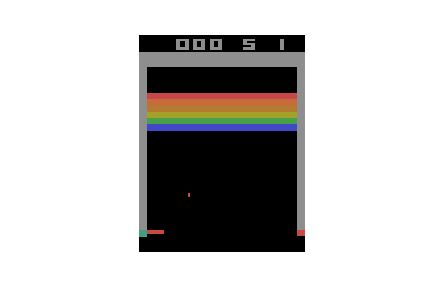
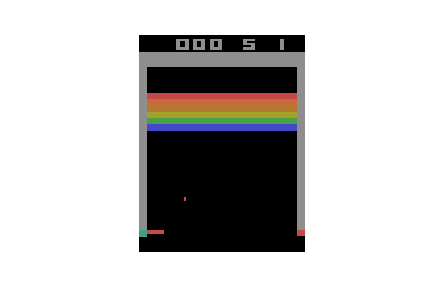
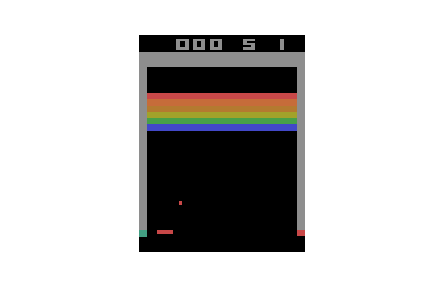
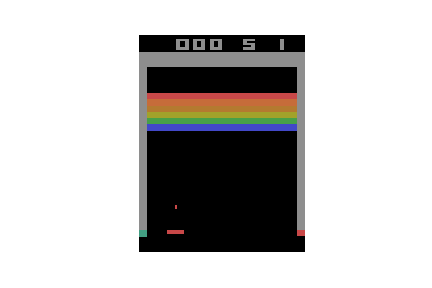
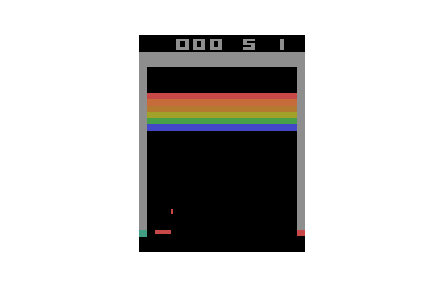
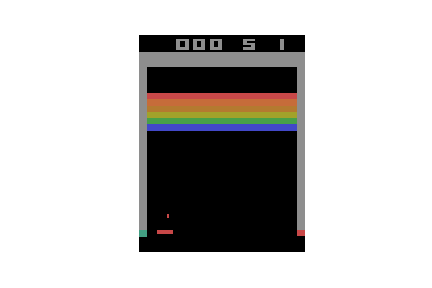
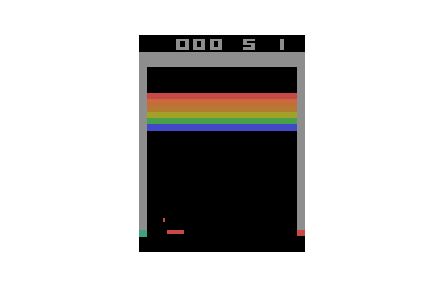
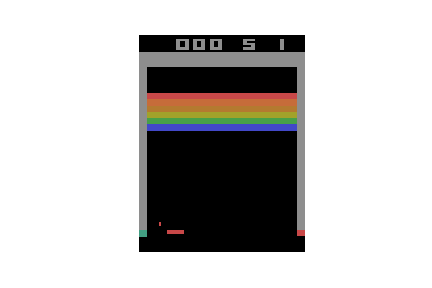
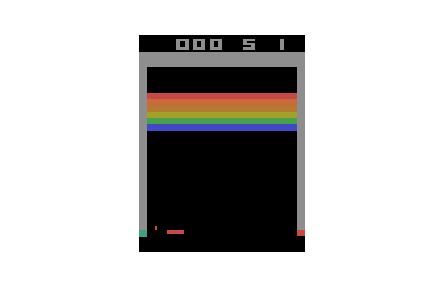
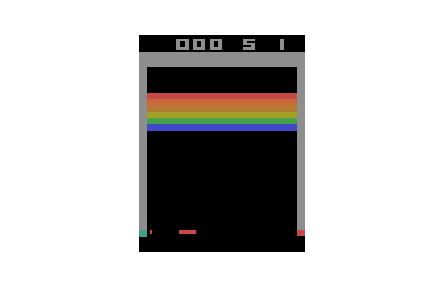
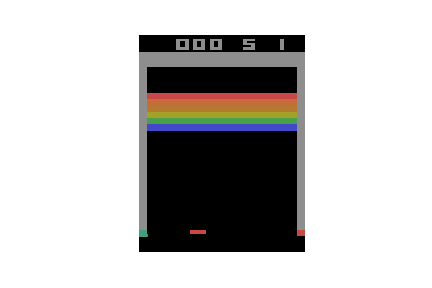
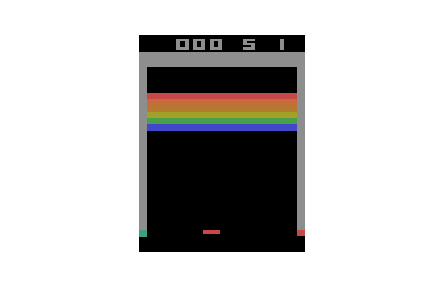
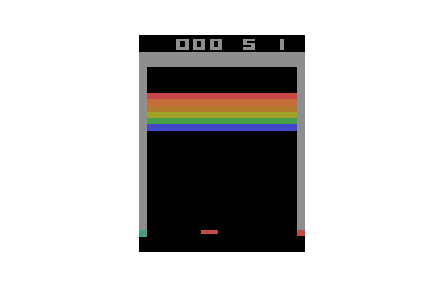
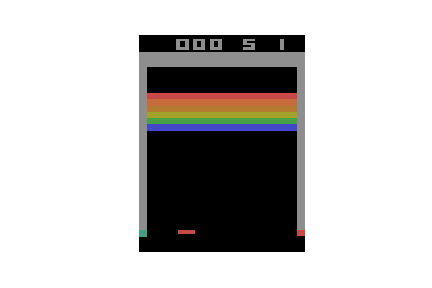
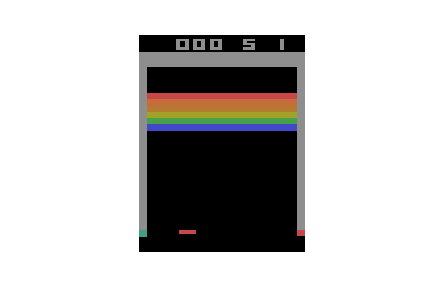
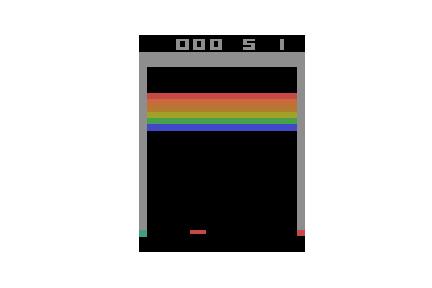
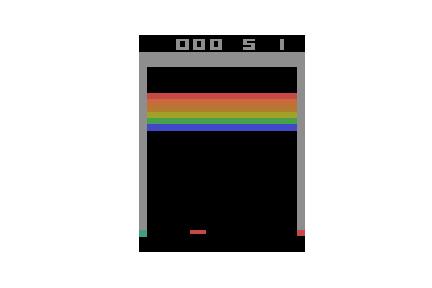
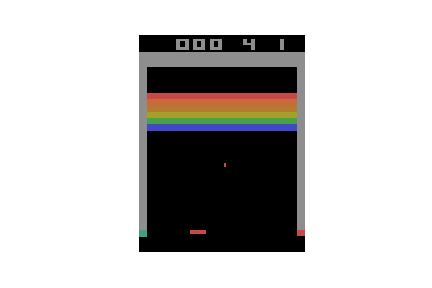
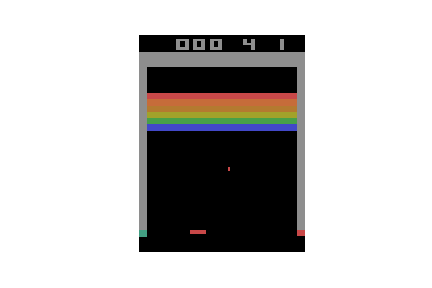
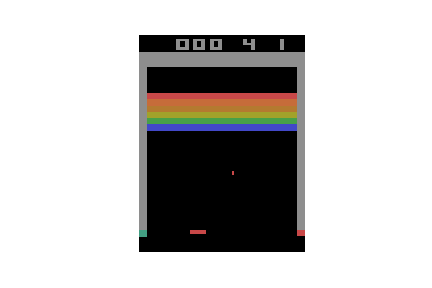
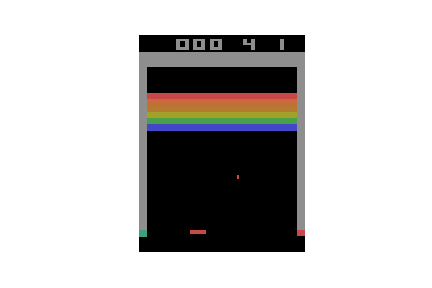
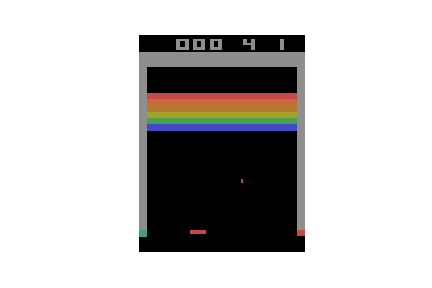
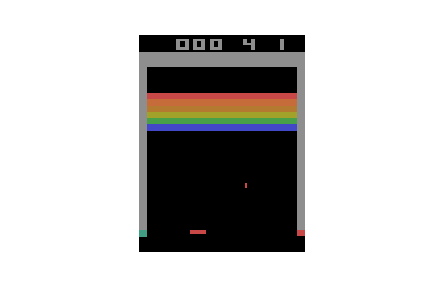
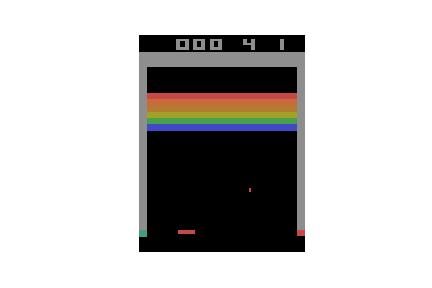
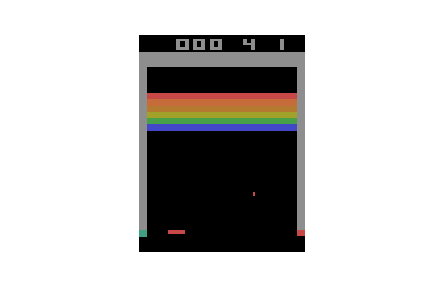
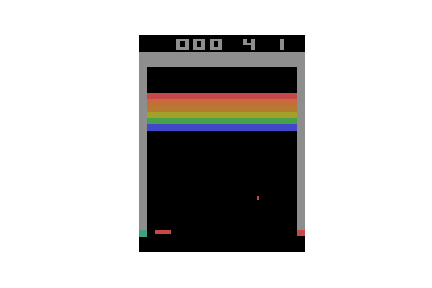
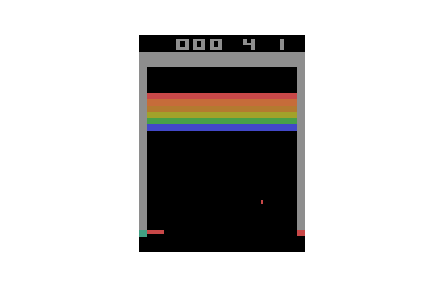
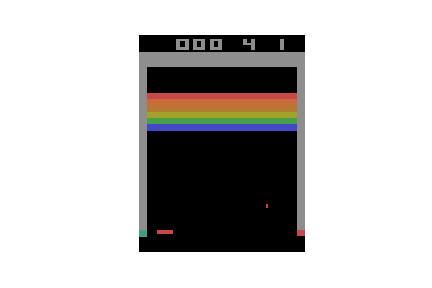
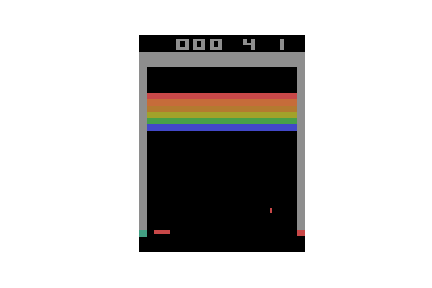
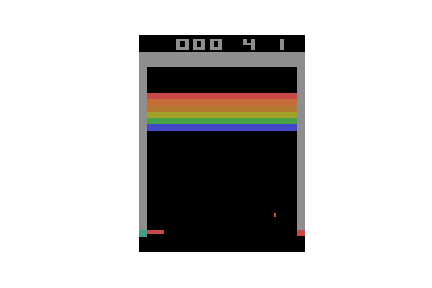
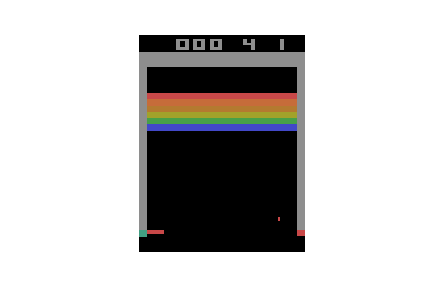
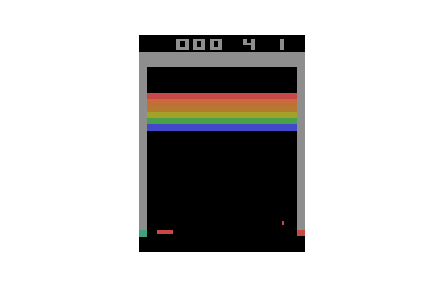
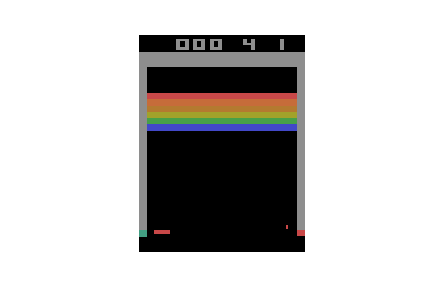
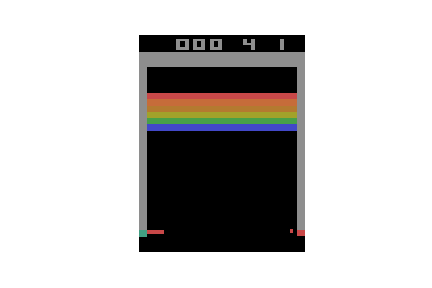
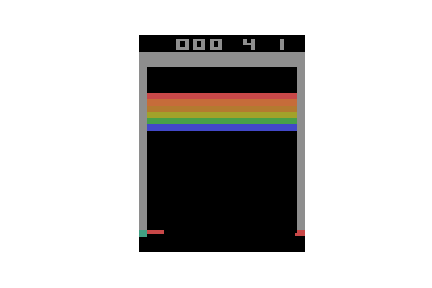
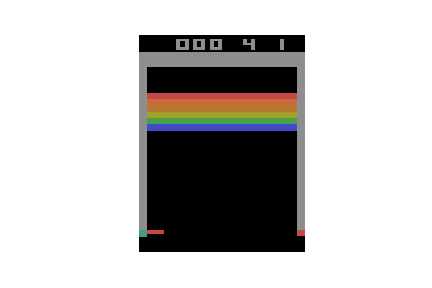
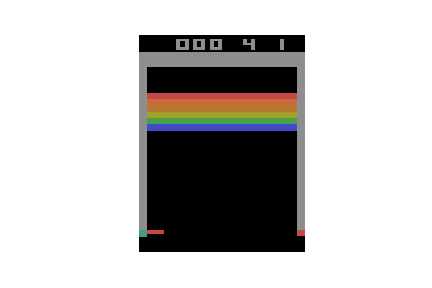
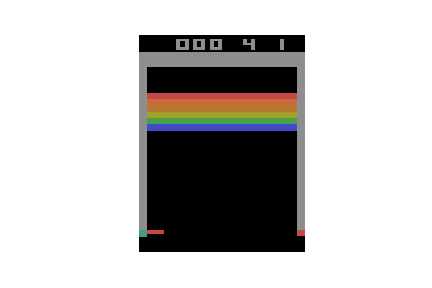
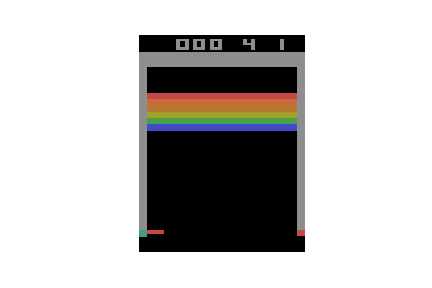
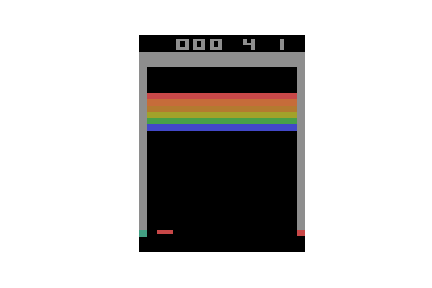
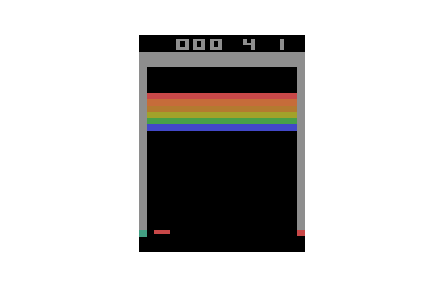
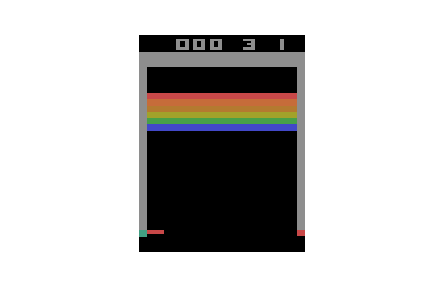
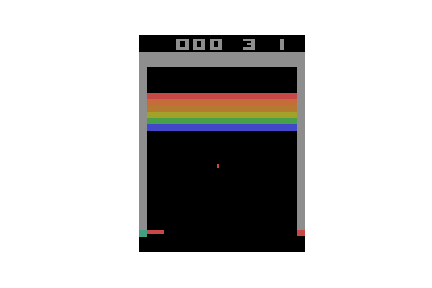
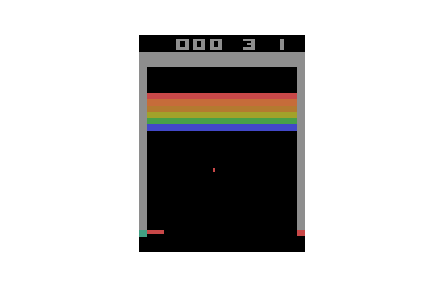
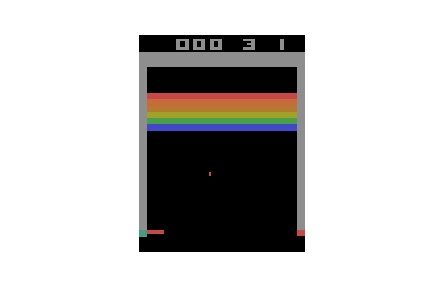
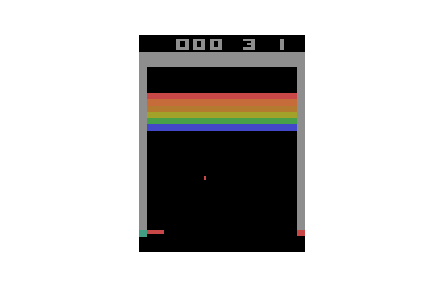
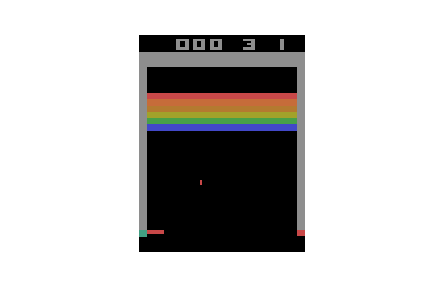
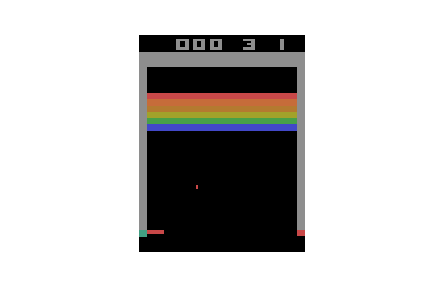
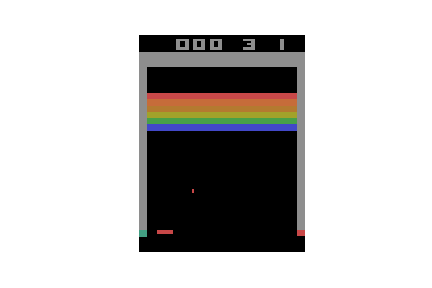
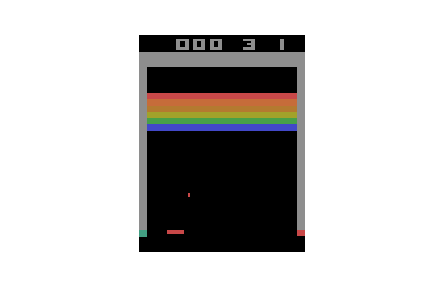
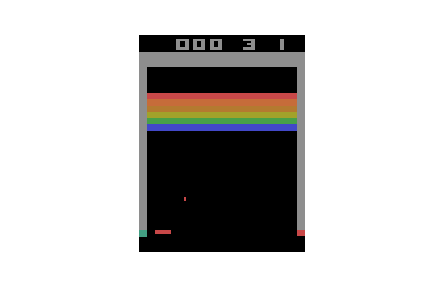
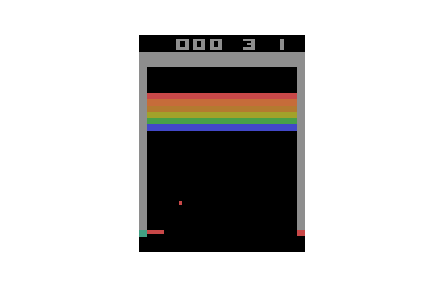
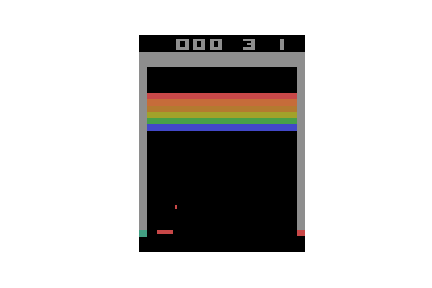
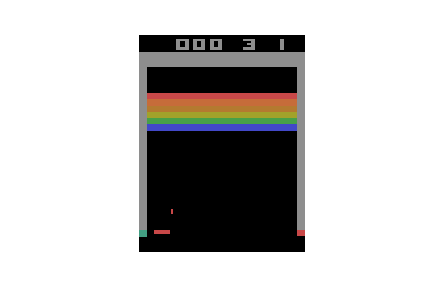
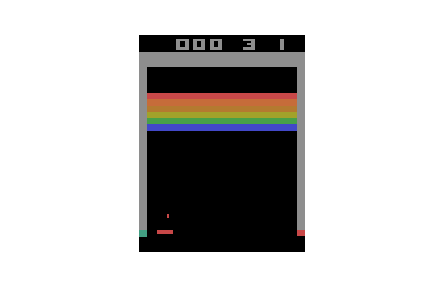
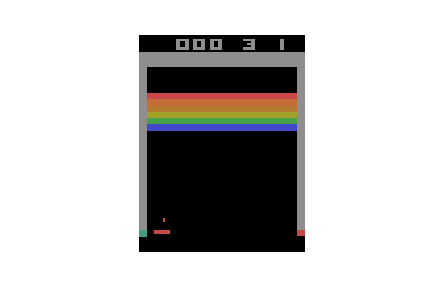
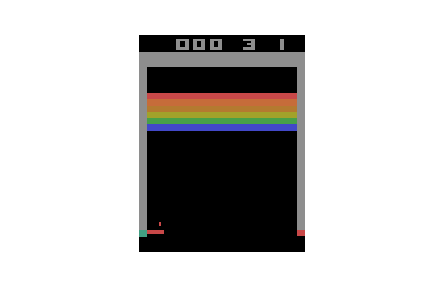
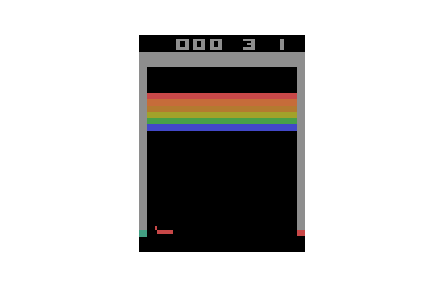
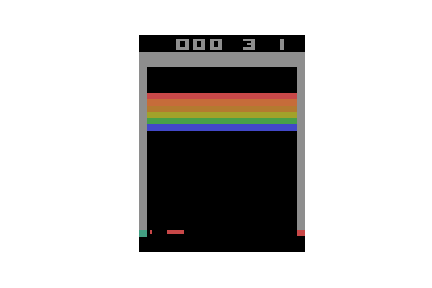
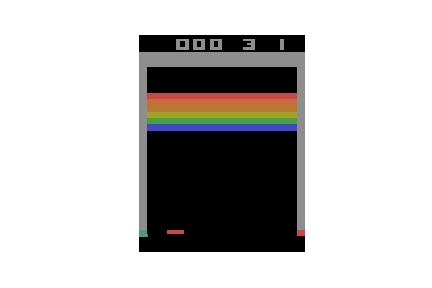
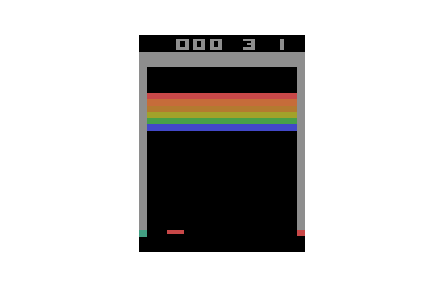
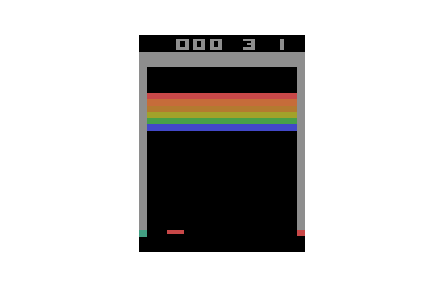
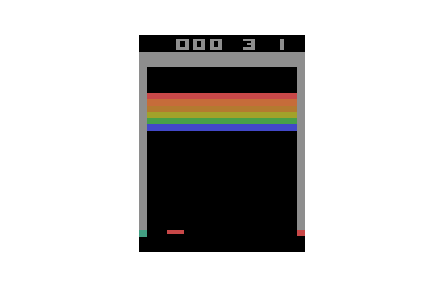
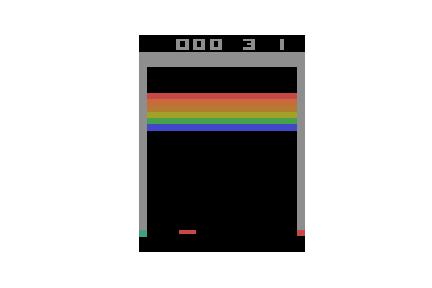
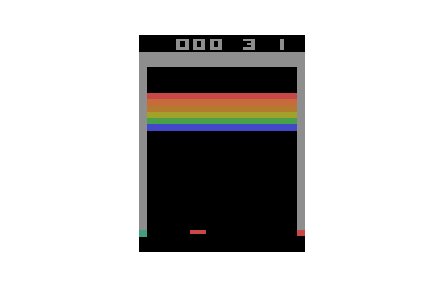
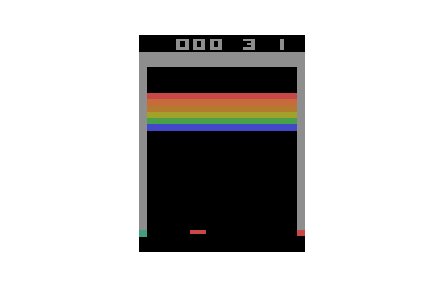
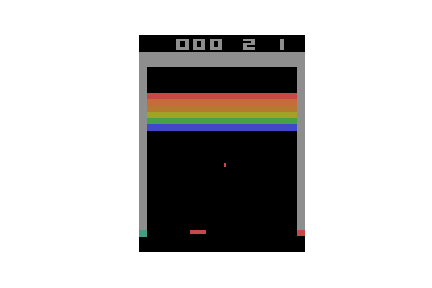
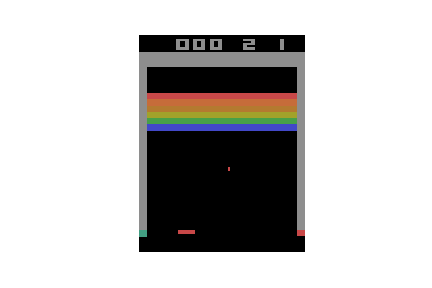
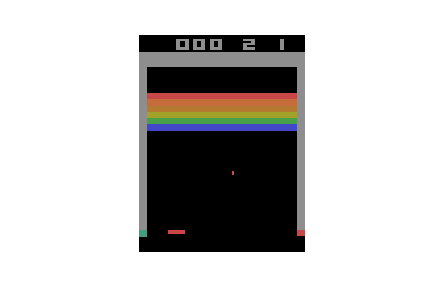
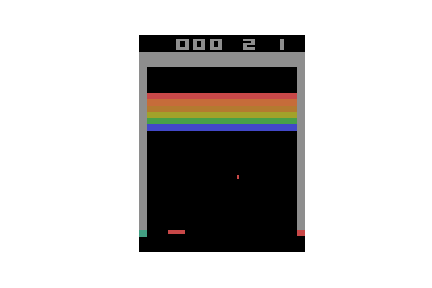
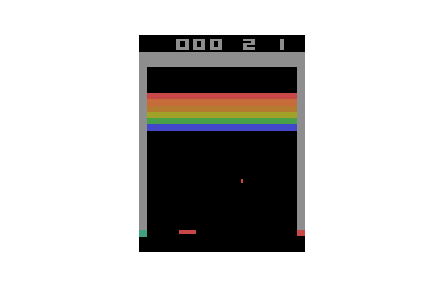
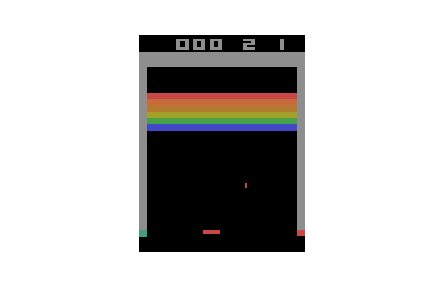
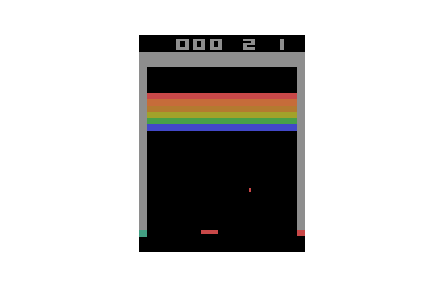
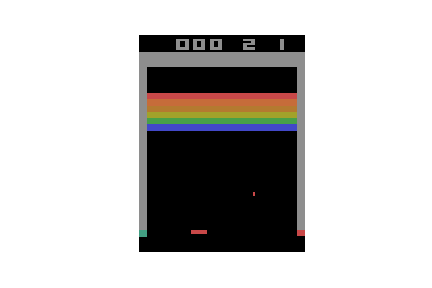
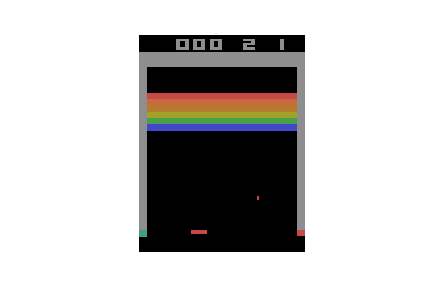
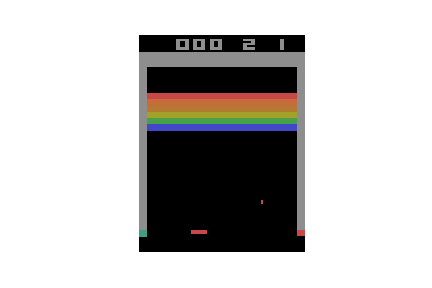
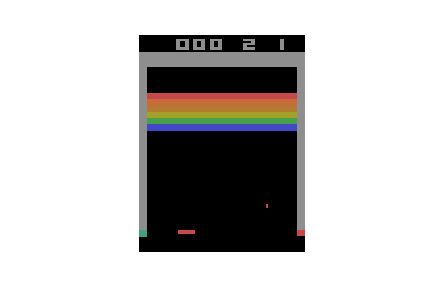
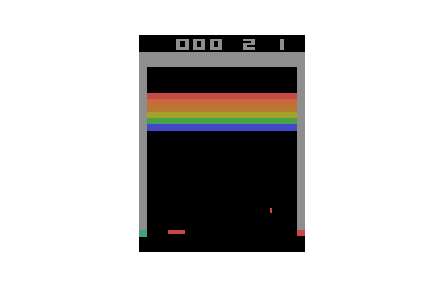
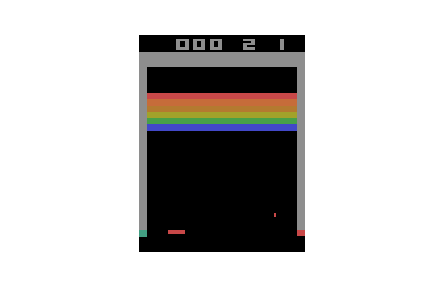
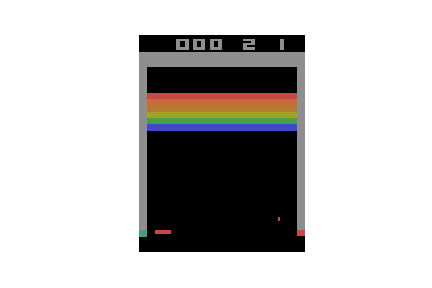
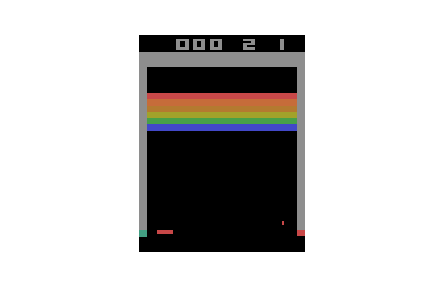
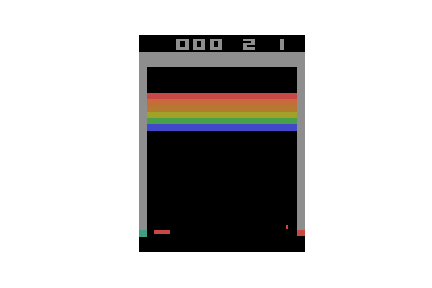
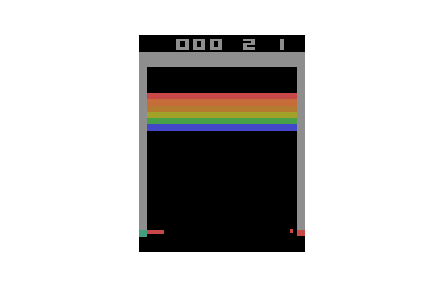
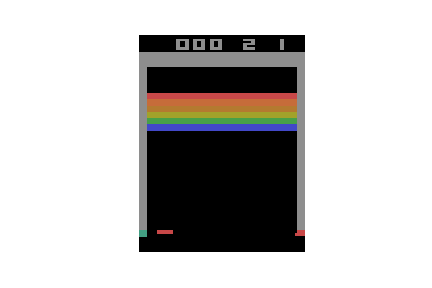
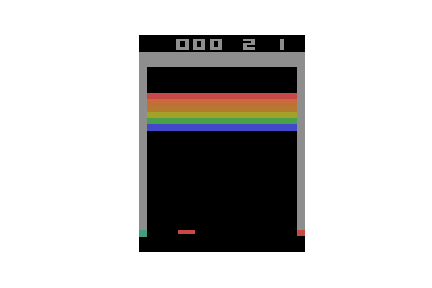
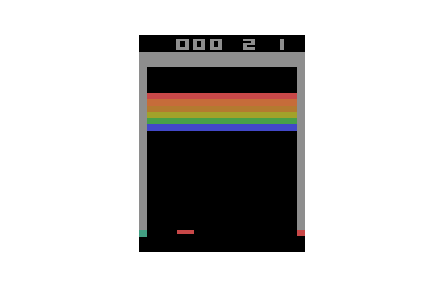
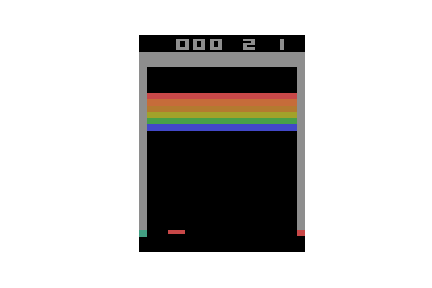
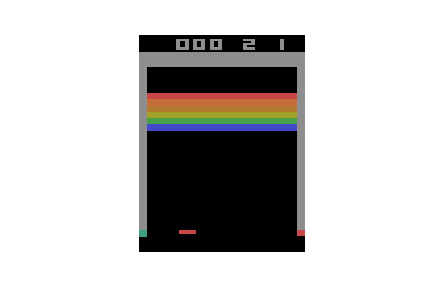
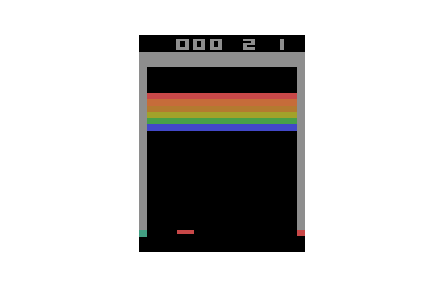
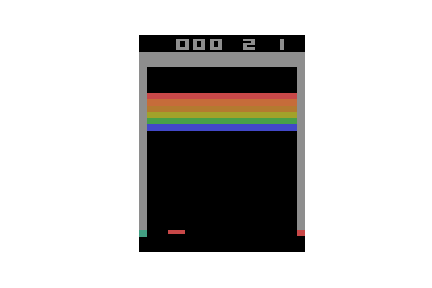
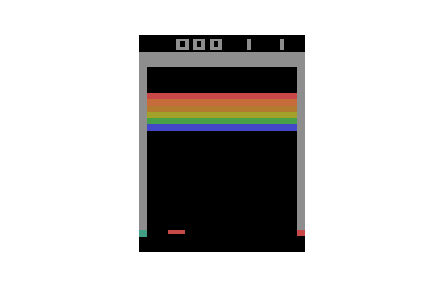
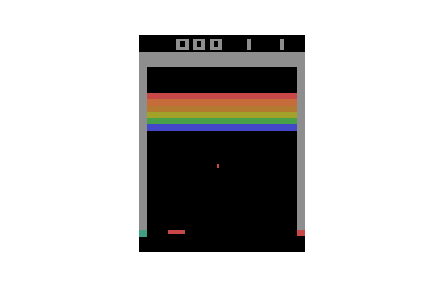
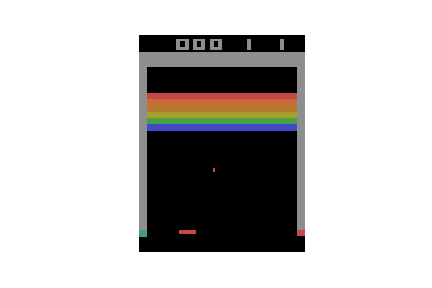
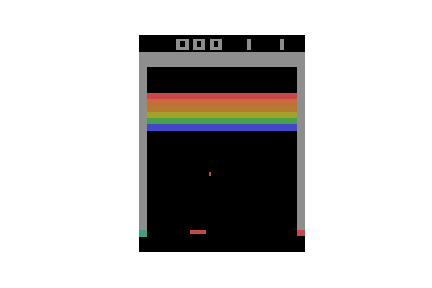
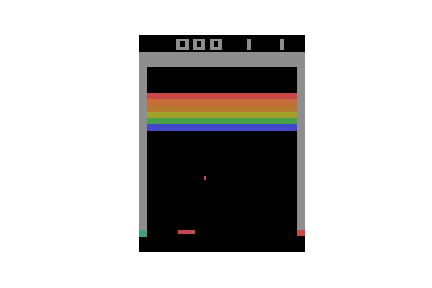
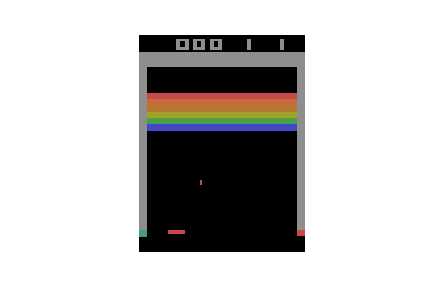
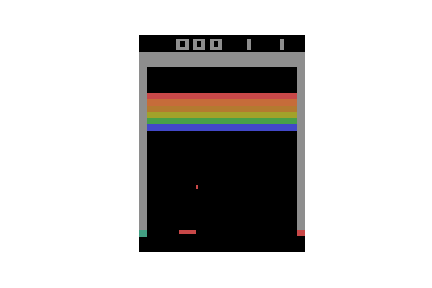
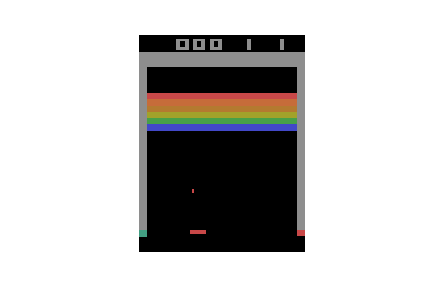
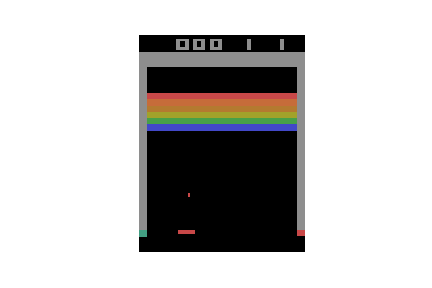
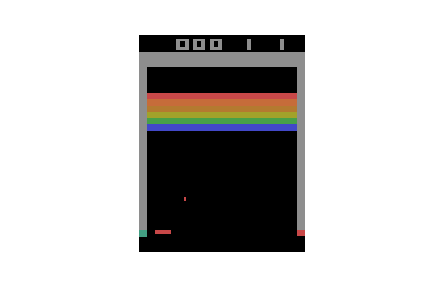
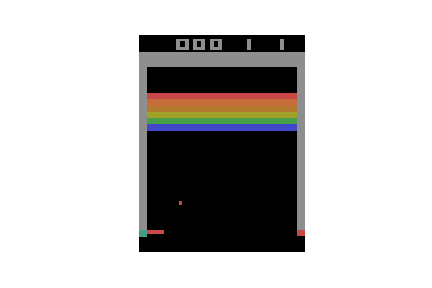
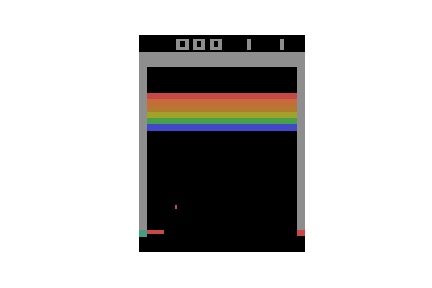
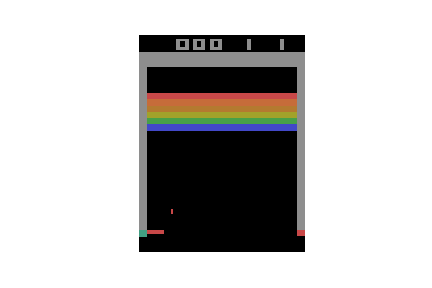
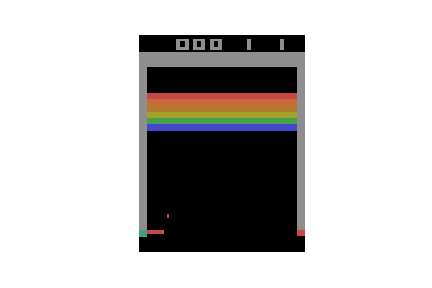
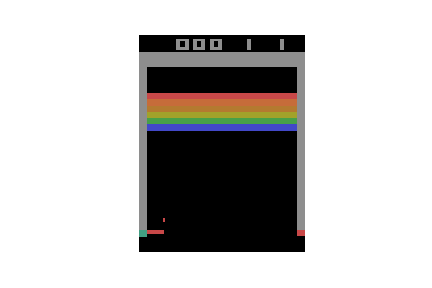
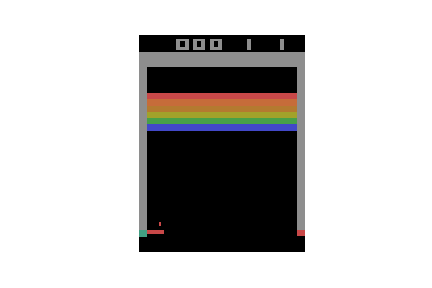
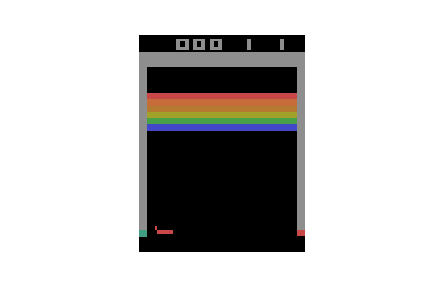
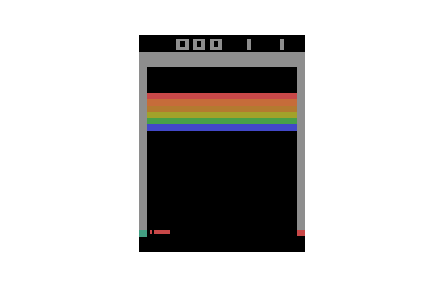
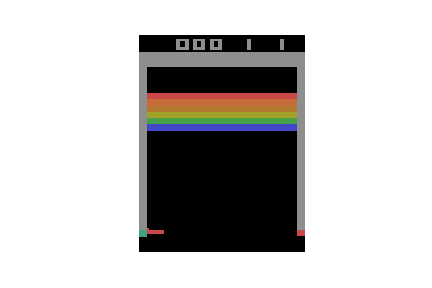
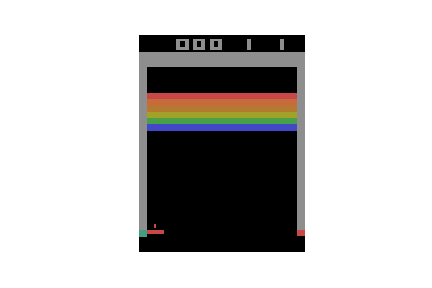
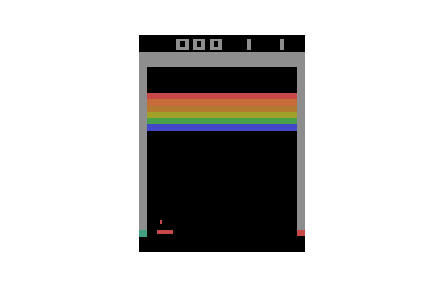
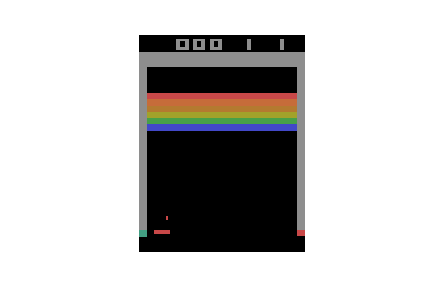
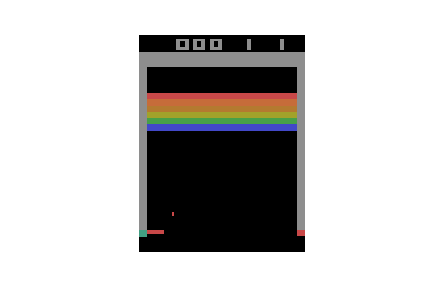
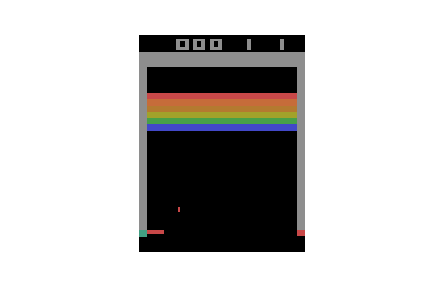
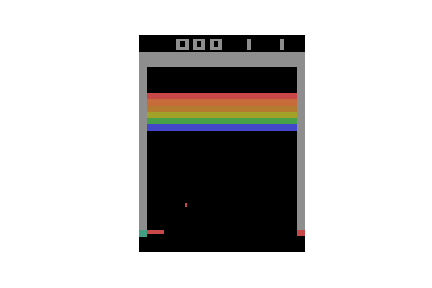
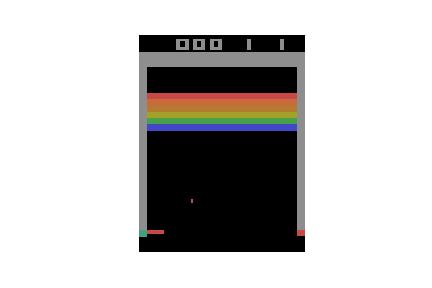
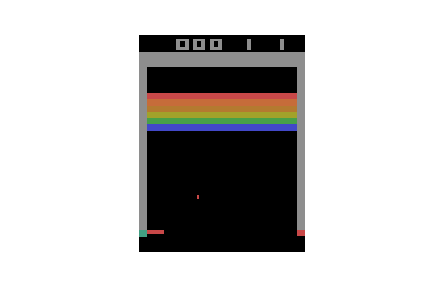
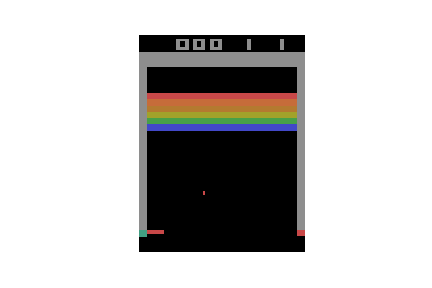
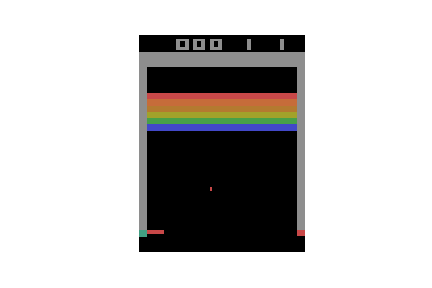
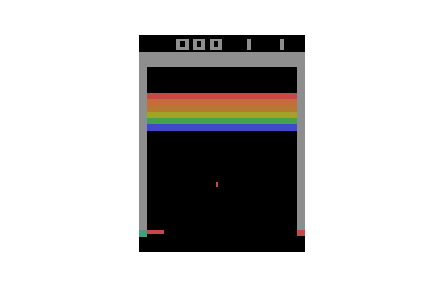
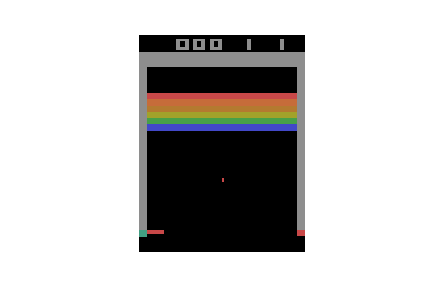
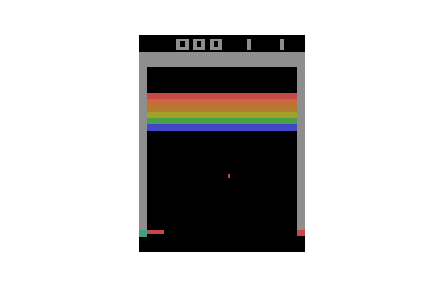
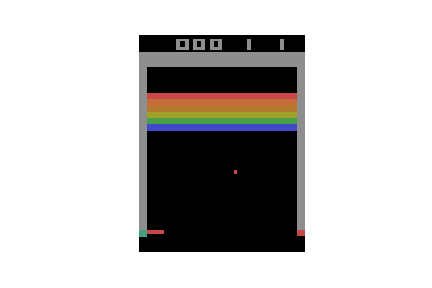
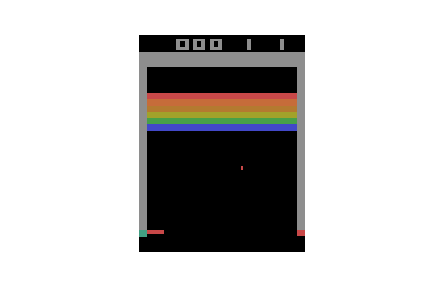
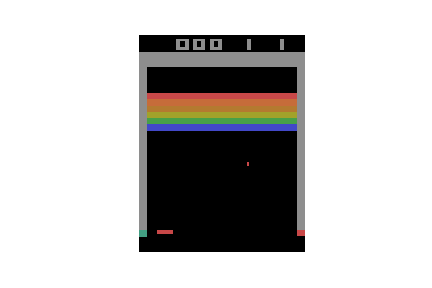
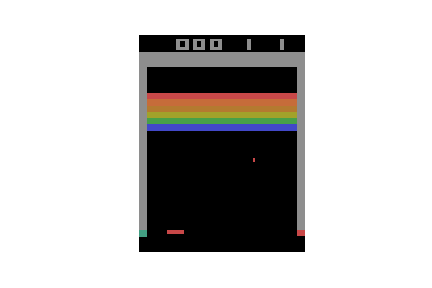
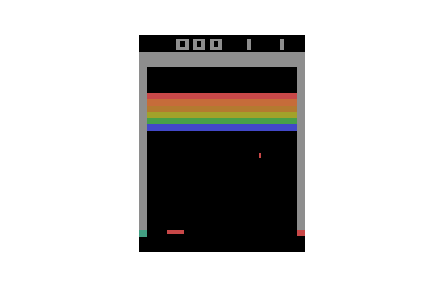
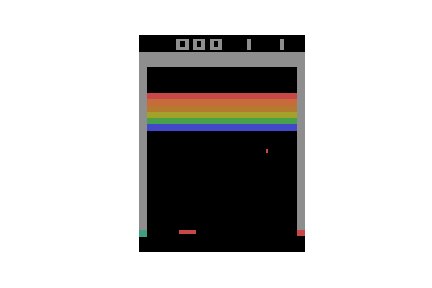
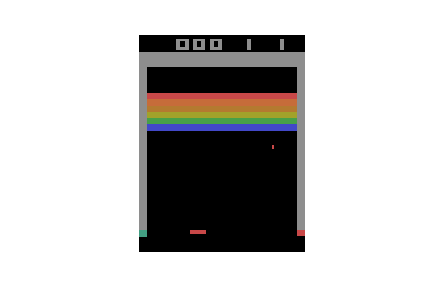
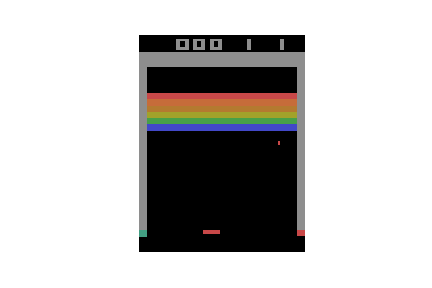
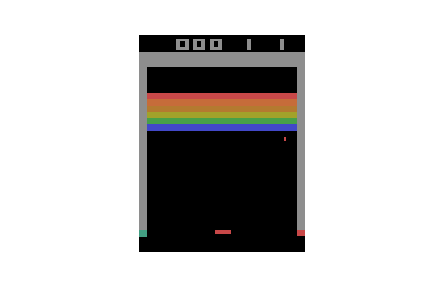
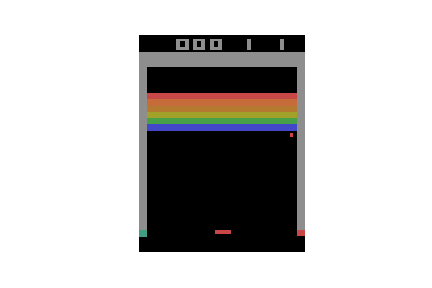
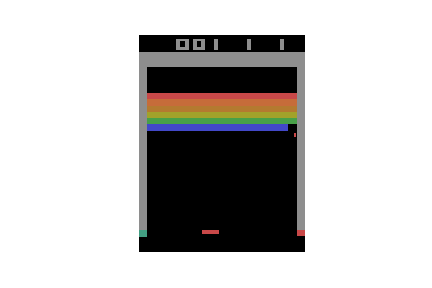
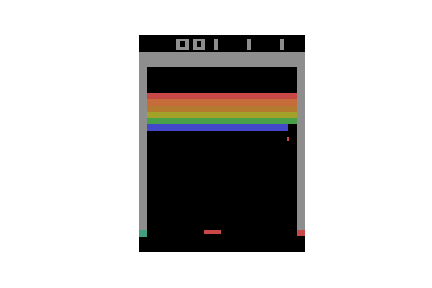
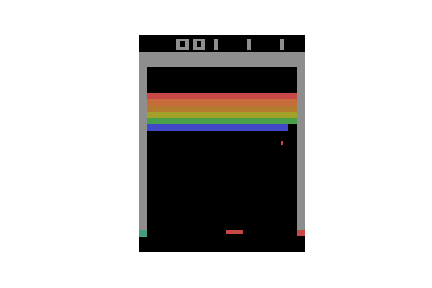
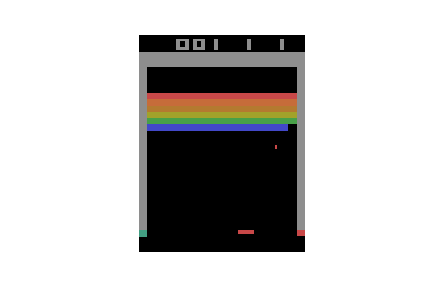
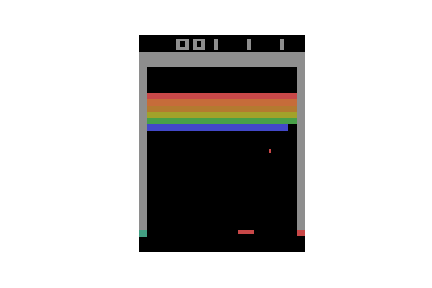
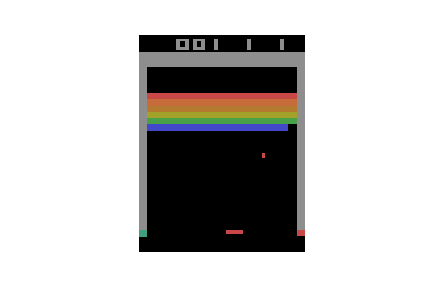
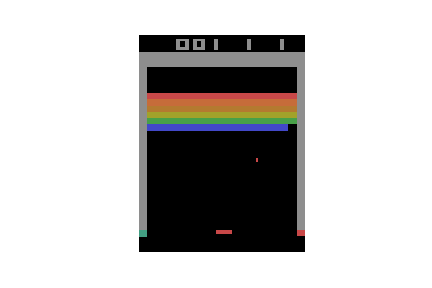
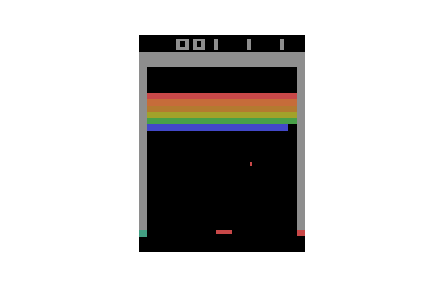
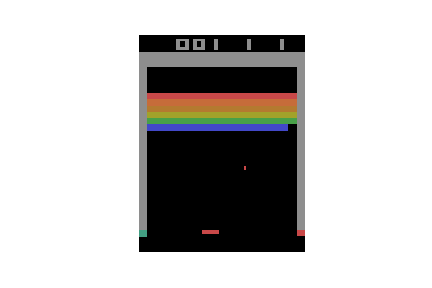
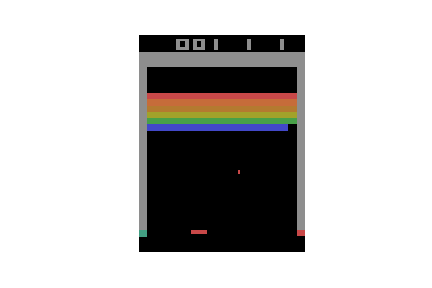
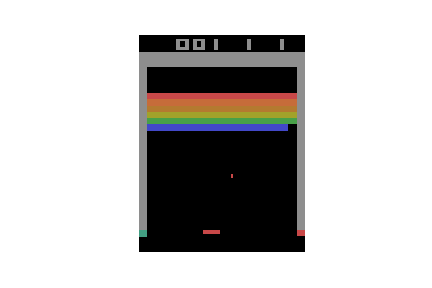
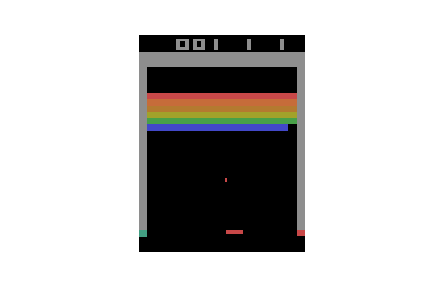
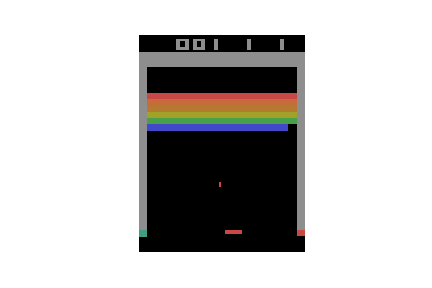
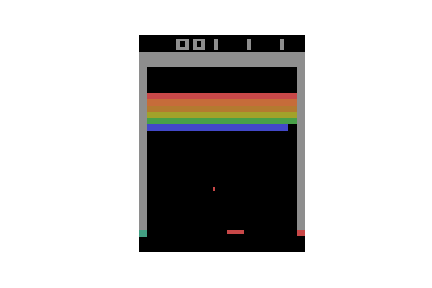
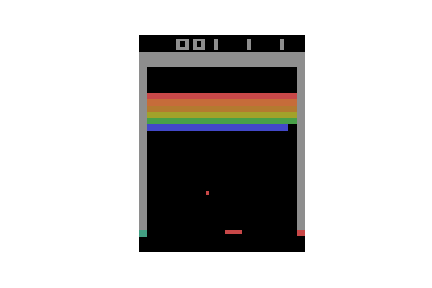
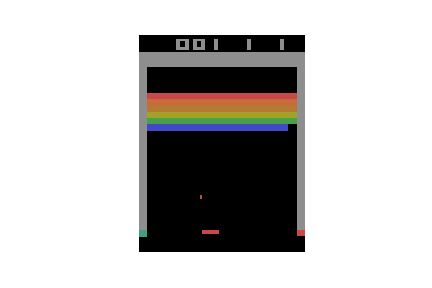
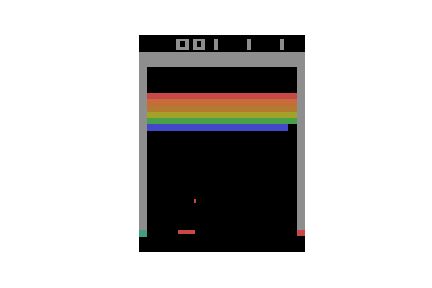
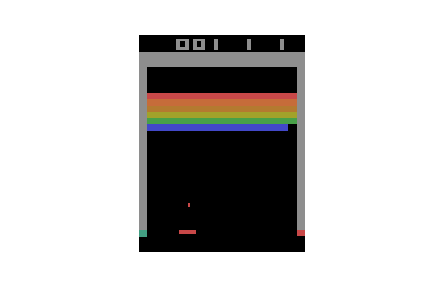
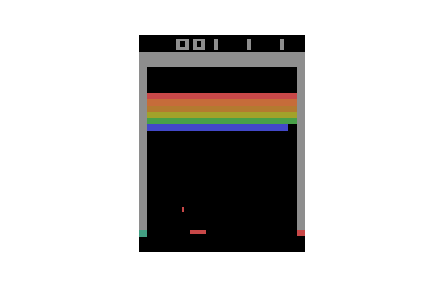
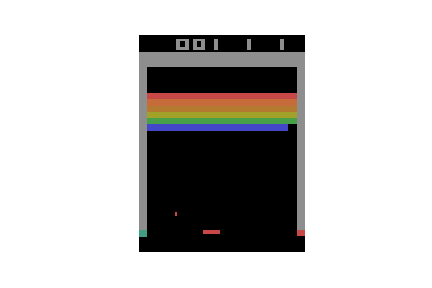
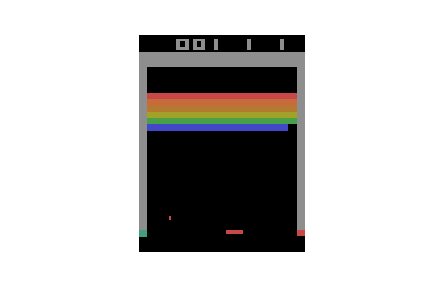
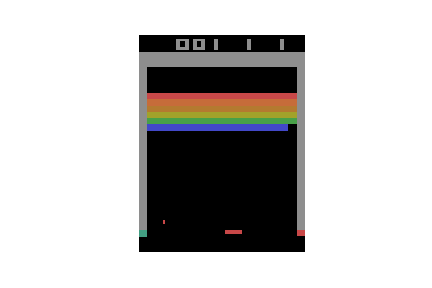
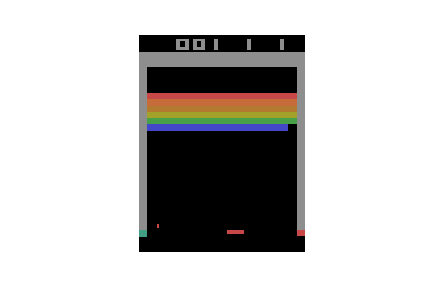
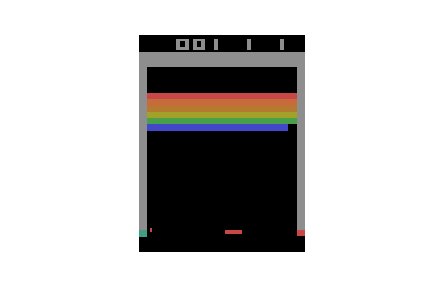
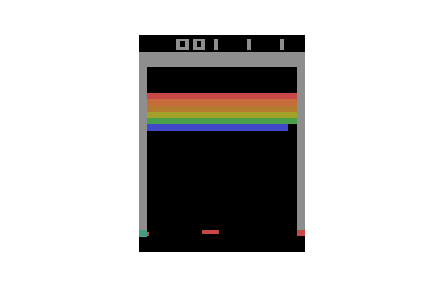
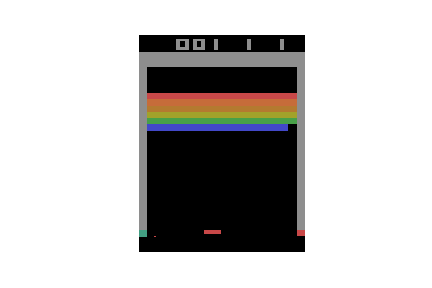
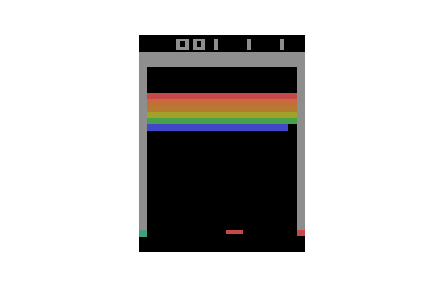
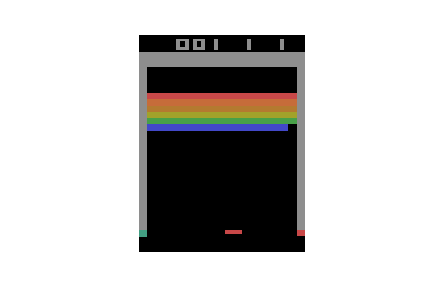
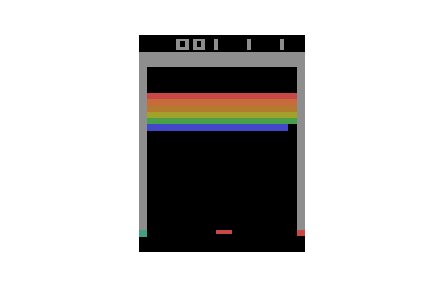
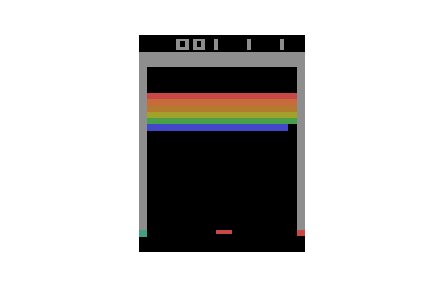
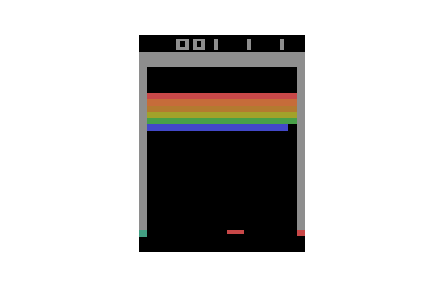
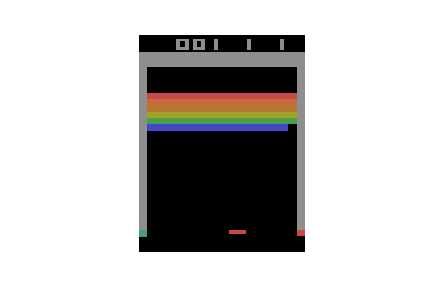

In [3]:

# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')
# Reset it, returns the starting frame
frames = []
frame = env.reset()
# Render
#env.render()

is_done = False
while not is_done:
  # Perform a random action, returns the new frame, reward and whether the game is over
  frame, reward, is_done, _ = env.step(env.action_space.sample())
  # Render
  frames.append(env.render(mode = 'rgb_array'))
env.close()
display_frames_as_gif(frames)


# Preprocessing

In [4]:
def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

def downsample(img):
    return img[::2, ::2]

def preprocess(img):
    return to_grayscale(downsample(img))

In [5]:
# Note: pass in_keras=False to use this function with raw numbers of numpy arrays for testing
def huber_loss(a, b, in_keras=True):
    error = a - b
    quadratic_term = error*error / 2
    linear_term = abs(error) - 1/2
    use_linear_term = (abs(error) > 1.0)
    if in_keras:
        # Keras won't let us multiply floats by booleans, so we explicitly cast the booleans to floats
        use_linear_term = K.cast(use_linear_term, 'float32')
    return use_linear_term * linear_term + (1-use_linear_term) * quadratic_term

# The Model

In [6]:
def atari_model(n_actions):
    # We assume a tensorflow backend here, so the "channels" are last.
    ATARI_SHAPE = (105, 80, 4)

    # With the functional API we need to define the inputs.
    frames_input = keras.layers.Input(ATARI_SHAPE, name='frames')
    actions_input = keras.layers.Input((n_actions,), name='mask')

    # Assuming that the input frames are still encoded from 0 to 255. Transforming to [0, 1].
    normalized = keras.layers.Lambda(lambda x: x / 255.0)(frames_input)
    
    # "The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity."
    conv_1 = keras.layers.convolutional.Conv2D(16, (8, 8), activation="relu", strides=(4, 4))(normalized)
    # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
    conv_2 = keras.layers.convolutional.Conv2D(32, (4, 4), activation="relu", strides=(2, 2))(conv_1)
    # Flattening the second convolutional layer.
    conv_flattened = keras.layers.core.Flatten()(conv_2)
    # "The final hidden layer is fully-connected and consists of 256 rectifier units."
    hidden = keras.layers.Dense(256, activation='relu')(conv_flattened)
    # "The output layer is a fully-connected linear layer with a single output for each valid action."
    output = keras.layers.Dense(n_actions)(hidden)
    # Finally, we multiply the output by the mask!
    filtered_output = multiply([output, actions_input])

    model = keras.models.Model(inputs=[frames_input, actions_input], outputs=filtered_output)
    optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
    model.compile(optimizer, loss=huber_loss)
    return model

## Memory Tool

The idea behind experience replay is quite simple: at each Q-learning iteration, you play one step in the game, but instead of updating the model based on that last step, you add all the relevant information from the step you just took (current state, next state, action taken, reward and whether the next state is terminal) to a finite-size memory (of 1,000,000 elements in this case), and then call fit_batch on a sample of that memory (of 32 elements in our case). Before doing any iterations on the neural network, we prefill the memory with a random policy up to a certain number of elements (50,000 in our case).


This ring buffer supports most of what you would expect (iteration, getting an arbitrary item etc.), but won’t work with random.sample. I recommend you simply implement a quick random sampling function for this. It shouldn’t be hard.

In [7]:
class RingBuf:
    def __init__(self, size):
        # Pro-tip: when implementing a ring buffer, always allocate one extra element,
        # this way, self.start == self.end always means the buffer is EMPTY, whereas
        # if you allocate exactly the right number of elements, it could also mean
        # the buffer is full. This greatly simplifies the rest of the code.
        self.data = [None] * (size + 1)
        self.start = 0
        self.end = 0
        self.is_full = False
        
    def append(self, element):
        self.data[self.end] = element
        self.end = (self.end + 1) % len(self.data)
        # end == start and yet we just added one element. This means the buffer has one
        # too many element. Remove the first element by incrementing start.
        if self.end == self.start:
            self.start = (self.start + 1) % len(self.data)
            self.is_full = True
            
    def add(self, state, action, new_frame, reward, is_done):
        self.append((state, action, new_frame, reward, is_done))

    def sample_batch(self, length):
        """
        Returns states_batch, action_batch, next_states_batch, reward_batch, done_batch
        """
        if length > len(self):
            samples =  self.data
        if self.is_full:
            indices = np.random.randint(0, len(self.data), length)
            samples =  [self.data[i] for i in indices]
        else:
            indices = np.random.randint(self.start, self.end, length)
            samples =  [self.data[i] for i in indices]
        return map(np.array, zip(*samples))
            
        
    def __getitem__(self, idx):
        return self.data[(self.start + idx) % len(self.data)]
    
    def __len__(self):
        if self.end < self.start:
            return self.end + len(self.data) - self.start
        else:
            return self.end - self.start
        
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

In [8]:
test = RingBuf(100000)
for i in range(120000):
    test.append((np.array([i, i + 1, i + 2, i + 3]), "asd"))

In [9]:
i, i2 = test.sample_batch(32)
i, i2
del test

# Putting it all together

Here are some functions that you have to implement yourself when following the blog post. These are called in the `q_iteration` function. Also the `sample_batch` function got added to the `RingBuf` class.

In [10]:
def get_epsilon_for_iteration(iteration):
    if(iteration >= 1000000):
        return 0.1
    else:
        return (-9e-7) * iteration + 1 

In [11]:
get_epsilon_for_iteration(0)

1.0

In [12]:
get_epsilon_for_iteration(999999)

0.10000090000000006

In [13]:
get_epsilon_for_iteration(1000000)

0.1

In [14]:
def choose_best_action(epsilon, model, state):
    
    if np.random.random() < epsilon:
        return env.action_space.sample()
    
    state_ext = np.expand_dims(state, axis=0)
    action_mask = np.ones((4,state.shape[-1]))
    logits = model.predict([state_ext,action_mask])[0]
    # TODO: do not use argmax but multinomal (needs a softmax layer?)
    return np.argmax(logits)

The paper suggests to input the last four frames to the network, so it can figure out what the speed, directetion and acceleration of an object is. At the beginning of each game, we will initialise a buffer with 4 times the very first frame. Each game step we will remove the oldest frame and append the new frame. To do that we will implement functions that help updating the buffer.

*At first I implemented a class, which is a bit nicer code wise. But I ran into memory issues, I think by keeping the elements in a class, multiple copies of the same frame are made*

In [15]:
def init_state_buffer(size, frame):
    return np.stack([frame] * size, axis = 2)

def update_state_buffer(state_buffer, new_frame):
    return np.append(state_buffer[:,:,1:], np.expand_dims(new_frame, axis=2), axis = 2)

In the paper [Human-level control through deep reinforcement
learning](http://www.davidqiu.com:8888/research/nature14236.pdf) DeepMind suggests using a separate network to predict target values and only update that network every 10000 iterations. 

In [16]:
def copy_model(model):
    model_copy = keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())
    return model_copy

# Training Loop

Check if GPU is available with tensorflow.

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4660492577062718750
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7453920461
locality {
  bus_id: 1
}
incarnation: 13139805795553730971
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Hyperparams

In [18]:

MINIBATCH_SIZE = 32
REPLAY_MEMORY_SIZE = 200000 # maximum I can fit in my 16GB RAM
AGENT_HISTORY_LENGTH = 4
DISCOUNT_FACTOR = 0.99
ACTION_REPEAT = 1 
REPLAY_START_SIZE = 50000
TARGET_MODEL_UPDATE_INTERVALL = 10000
MAXIMUM_ITERATIONS = 50000000

!mkdir videos
monitor_path = "./videos"
record_video_every = 20

!mkdir models
save_model_every = 20

mkdir: cannot create directory ‘videos’: File exists
mkdir: cannot create directory ‘models’: File exists


### Init

In [19]:
env = gym.make('BreakoutDeterministic-v4')
first_state = preprocess(env.reset())
state = init_state_buffer(AGENT_HISTORY_LENGTH, first_state)
memory = RingBuf(REPLAY_MEMORY_SIZE)
model = atari_model(env.action_space.n)
target_model = copy_model(model)
restart = False
iteration = 0


In [20]:
model_paths = glob.glob("./models/ep_*.hdf5")
model_paths.sort(key= lambda x: int(x.split("_")[1]))
if len(model_paths) > 0:
    latest_model = model_paths[-1]
    start_episode = int(re.match("./models/ep_([0-9]+)_itr_([0-9]+).hdf5", latest_model).group(1))
    iteration = int(re.match("./models/ep_([0-9]+)_itr_([0-9]+).hdf5", latest_model).group(2))
    epsilon = get_epsilon_for_iteration(iteration)
    model.load_weights(latest_model)
    target_model = copy_model(model)
    reward_history = list(np.loadtxt("./reward_history.csv"))

    restart = True
    print("Resuming from episode {}, iteration {}".format(start_episode, iteration))
else:
    print("A fresh start....")
    start_episode = 0
    reward_history = []

    

Resuming from episode 102020, iteration 45836721


### Fill Replay Memory with random actions

Or use a models decisions if we restart training from a saved model.

In [21]:
first_state = preprocess(env.reset())
state = init_state_buffer(AGENT_HISTORY_LENGTH, first_state)

for _ in tqdm(range(REPLAY_START_SIZE)):
    if not restart:
        action = env.action_space.sample()
    else:
        action = choose_best_action(epsilon, model, state)
        
    one_hot_action = keras.utils.np_utils.to_categorical(action, num_classes=env.action_space.n)

    for _ in range(ACTION_REPEAT):
        new_frame, reward, is_done, _ = env.step(action)
        new_frame = preprocess(new_frame)
        next_state = update_state_buffer(state, new_frame)
        if is_done:
            break
    memory.add(state, one_hot_action, next_state, reward, is_done)

    state = next_state
    if is_done:
        first_state = preprocess(env.reset())
        state = init_state_buffer(AGENT_HISTORY_LENGTH, first_state)


HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

### Train Model while playing

This function is from the blogpost.

In [22]:
def fit_batch(model, traget_model, gamma, start_states, actions, rewards, next_states, is_terminal):
    """Do one deep Q learning iteration.
    
    Params:
    - model: The DQN
    - traget_model: The target DQN
    - gamma: Discount factor (should be 0.99)
    - start_states: numpy array of starting states of shape [batch_size, 105, 80, 4]
    - actions: numpy array of one-hot encoded actions corresponding to the start states 
                of shape [batch_size, number_of_possible_actions]
    - rewards: numpy array of rewards corresponding to the start states and actions
    - next_states: numpy array of the resulting states corresponding to the start states 
                    and actions of shape [batch_size, 105, 80, 4]
    - is_terminal: numpy boolean array of whether the resulting state is terminal
    
    """
    # First, predict the Q values of the next states. Note how we are passing ones as the mask.
    next_Q_values = traget_model.predict([next_states, np.ones(actions.shape)])

    # The Q values of each start state is the reward + gamma * the max next state Q value
    #     or just reward when it is a terminal state
    Q_values = rewards + np.invert(is_terminal).astype(np.float32) * gamma * np.max(next_Q_values, axis=1)
    # Fit the keras model. Note how we are passing the actions as the mask and multiplying
    # the targets by the actions.
    model.fit(
        [start_states, actions], actions * Q_values[:, None],
        epochs=1, batch_size=len(start_states), verbose=0
    )

In [23]:
def q_iteration(env, model, target_model, gamma, batch_size, iteration, state, replay_memory):
    # Choose epsilon based on the iteration
    epsilon = get_epsilon_for_iteration(iteration)
    
    action = choose_best_action(epsilon, model, state)
    one_hot_action = keras.utils.np_utils.to_categorical(action, num_classes=env.action_space.n)

    for _ in range(ACTION_REPEAT):
        new_frame, reward, is_done, _ = env.step(action)
        new_frame = preprocess(new_frame)
        next_state = update_state_buffer(state, new_frame)
        if is_done:
            break
        
    memory.add(state, one_hot_action, next_state, reward, is_done)
    state = next_state
    
    # Sample and fit
    states_batch, action_batch, next_states_batch, reward_batch, done_batch = memory.sample_batch(batch_size)
    fit_batch(model,target_model, gamma, states_batch, action_batch, reward_batch, next_states_batch, done_batch)
    
    return state, is_done, reward

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

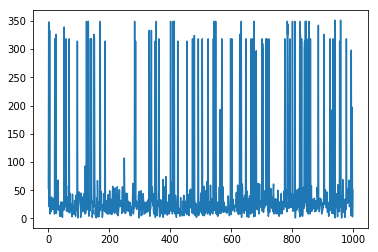

In [24]:
env = gym.make('BreakoutDeterministic-v4')
env = Monitor(env,
                  directory=monitor_path,
                  resume=True,
                  video_callable=lambda count: count % record_video_every ==0)

fig,ax = plt.subplots(1,1)

for episode in tqdm(itertools.count(start=start_episode)):
    total_reward = 0
    is_done = False
    first_state = preprocess(env.reset())
    state = init_state_buffer(AGENT_HISTORY_LENGTH, first_state)

    while not is_done:
        state, is_done, reward = q_iteration(env, model, target_model, DISCOUNT_FACTOR, MINIBATCH_SIZE, iteration, state, memory)
        total_reward += reward
        iteration += 1
        
        if iteration % TARGET_MODEL_UPDATE_INTERVALL == 0:
            target_model = copy_model(model)
        
    print("Finished game: {} with reward: {}. Replay Memory Size: {}. Iteration: {}".format(episode + 1, total_reward, len(memory), iteration), end='\r')
    reward_history.append(total_reward)
    
    ax.clear()
    ax.plot(reward_history[-1000:])
    fig.canvas.draw()
    
    if episode % save_model_every == 0:
        model.save_weights("./models/ep_{}_itr_{}.hdf5".format(episode, iteration))
        np.savetxt("./reward_history.csv", reward_history, fmt="%d", delimiter=",")
    if iteration >= MAXIMUM_ITERATIONS:
        break

In [25]:
#%load_ext line_profiler

In [26]:
#%lprun -f q_iteration q_iteration(env, model, target_model, DISCOUNT_FACTOR, MINIBATCH_SIZE, iteration, state, memory)

In [27]:
#%lprun -f memory.sample_batch memory.sample_batch(32)

In [28]:
#states_batch, action_batch, next_states_batch, reward_batch, done_batch = memory.sample_batch(32)
#%lprun -f fit_batch fit_batch(model,target_model, 0.99, states_batch, action_batch, reward_batch, next_states_batch, done_batch)

In [29]:
!mkdir models
model.save("./models/final.hdf5")


mkdir: cannot create directory ‘models’: File exists


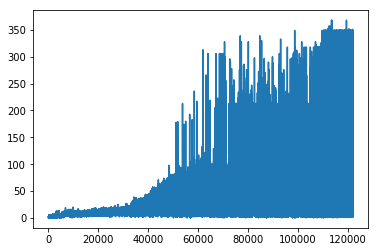

In [30]:
plt.plot(reward_history)

# Play a game


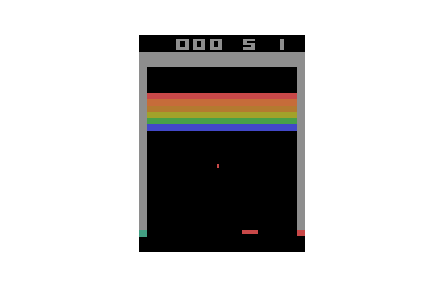
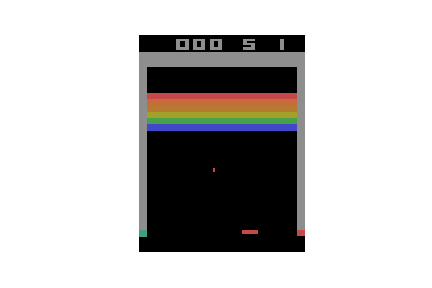
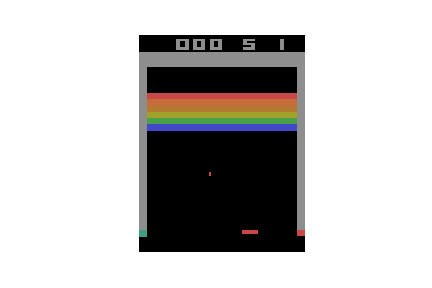
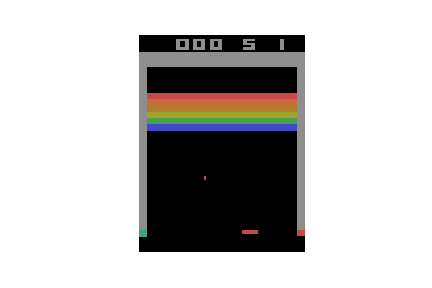
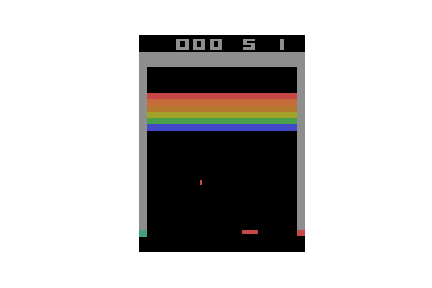
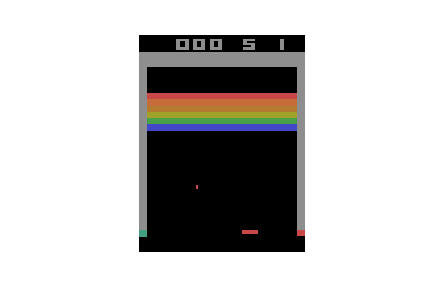
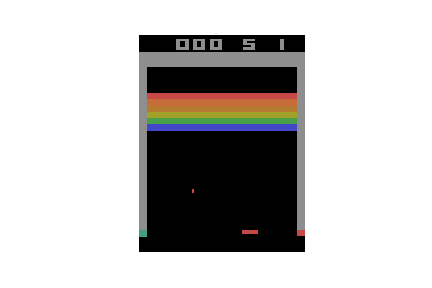
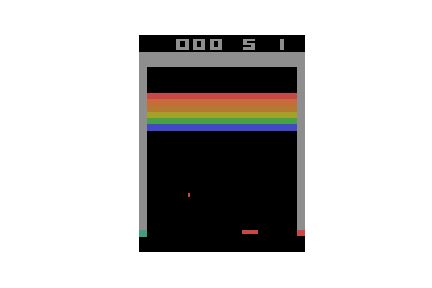
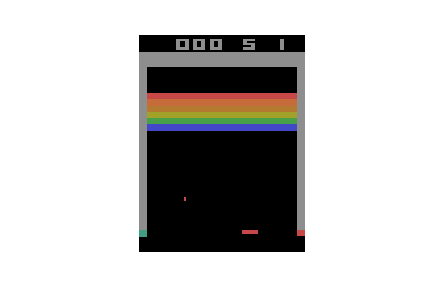
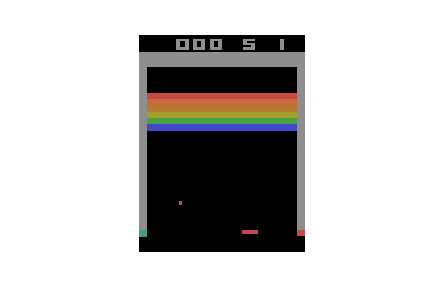
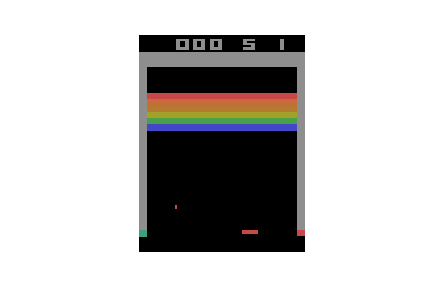
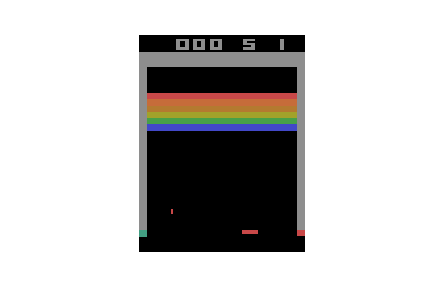
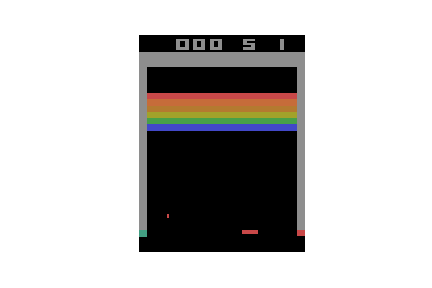
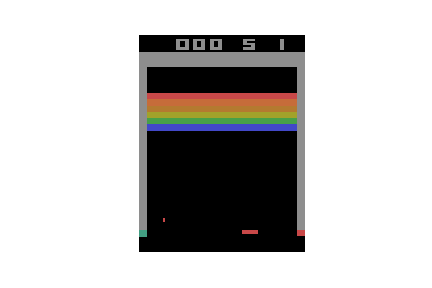
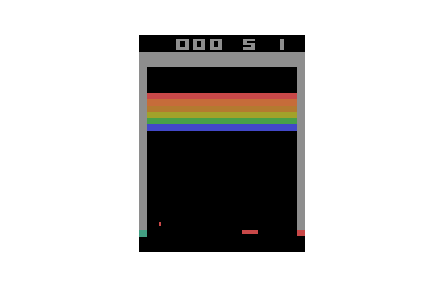
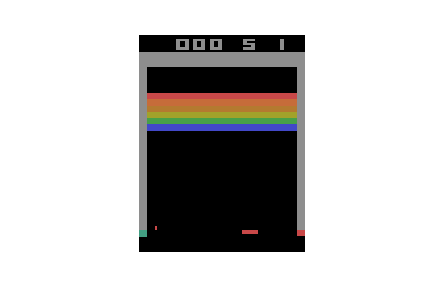
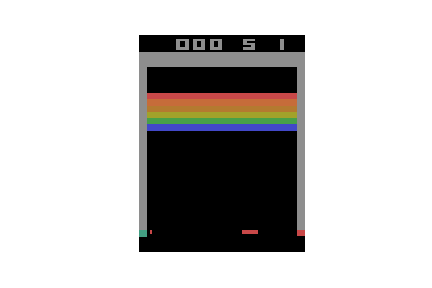
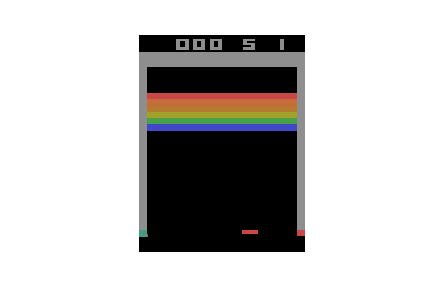
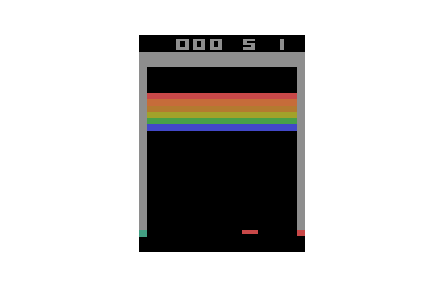
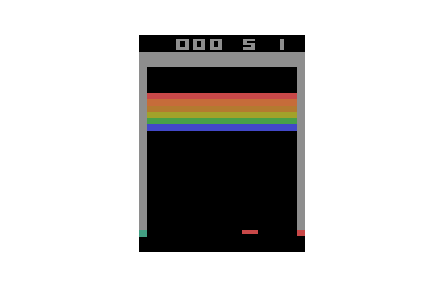
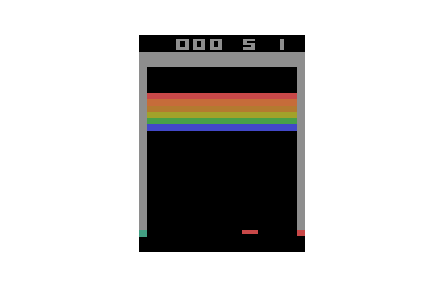
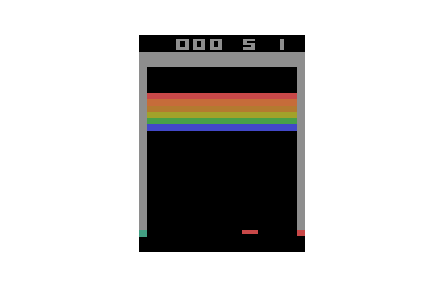
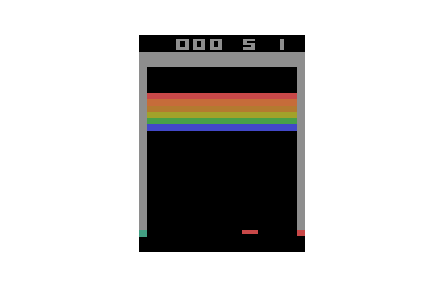
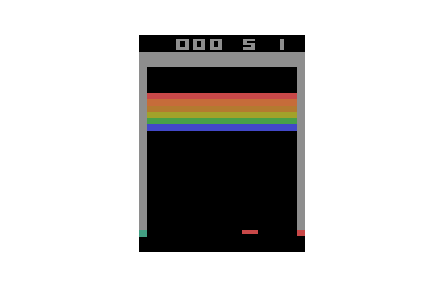
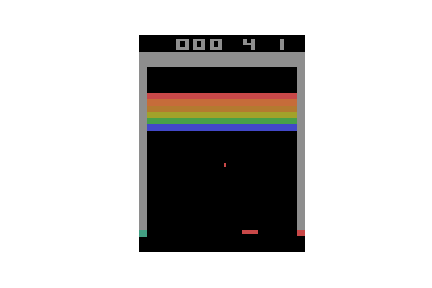
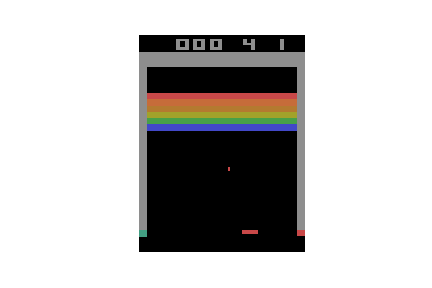
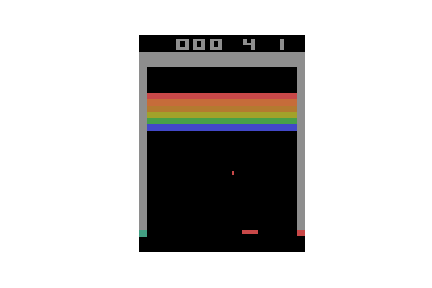
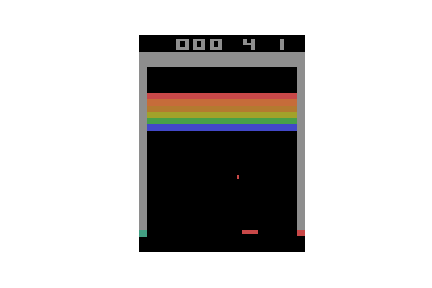
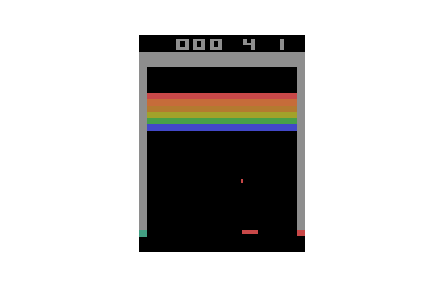
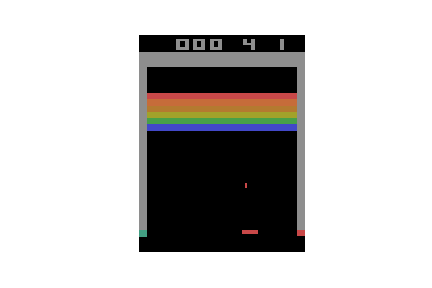
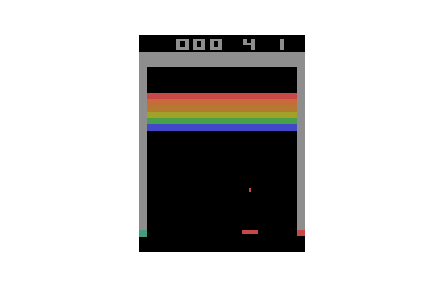
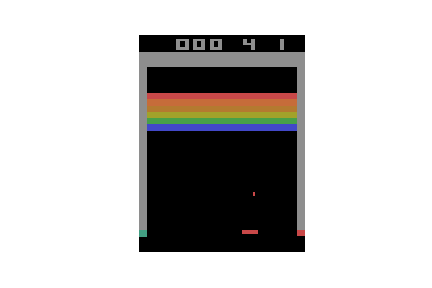
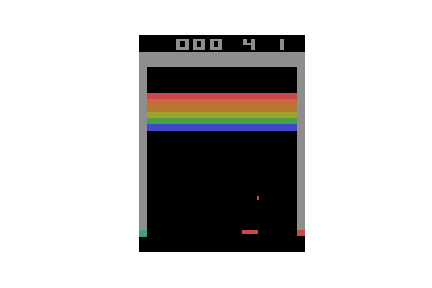
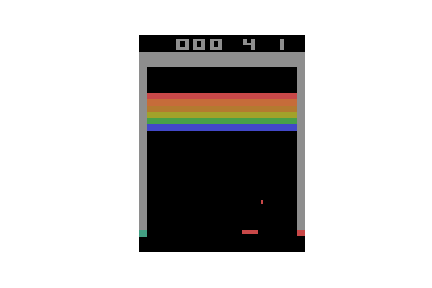
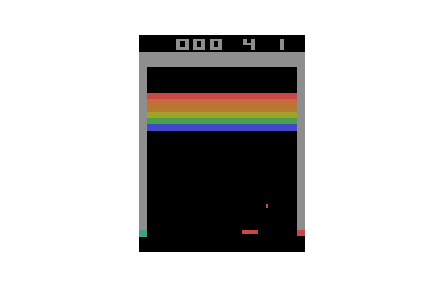
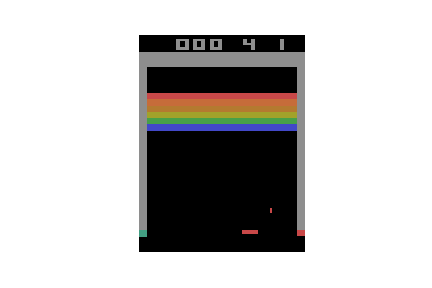
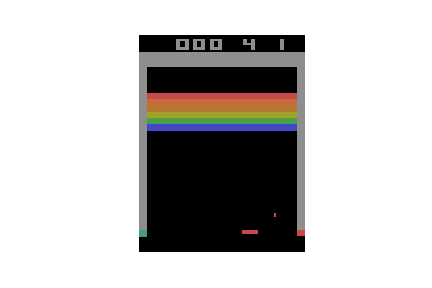
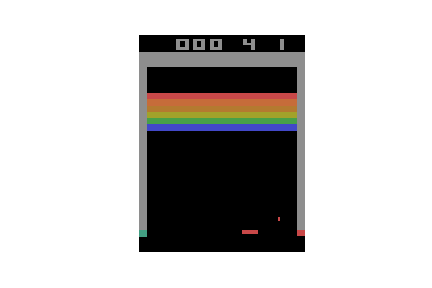
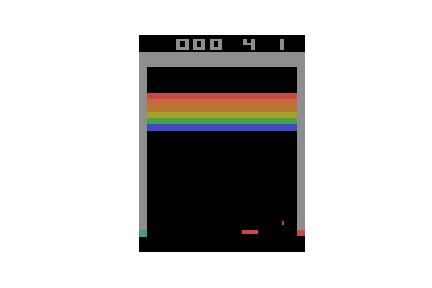
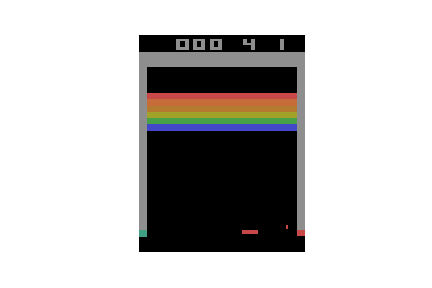
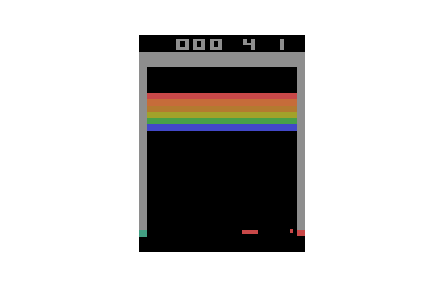
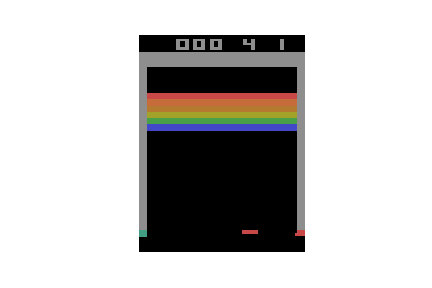
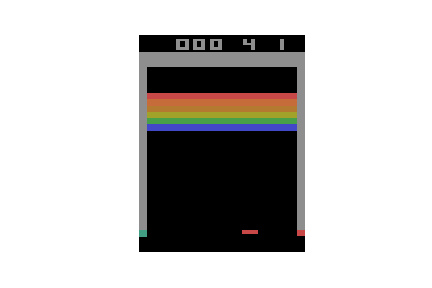
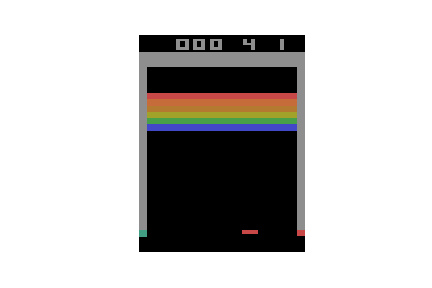
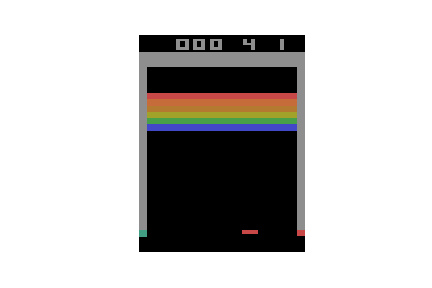
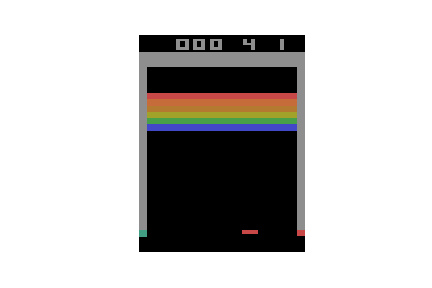
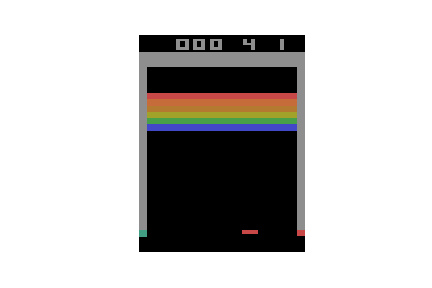
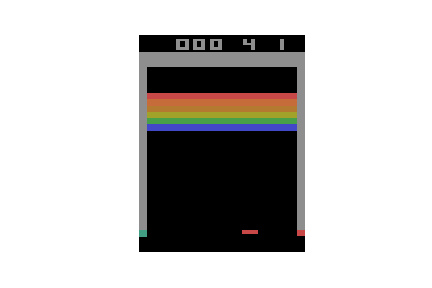
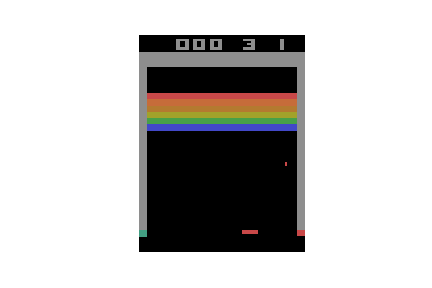
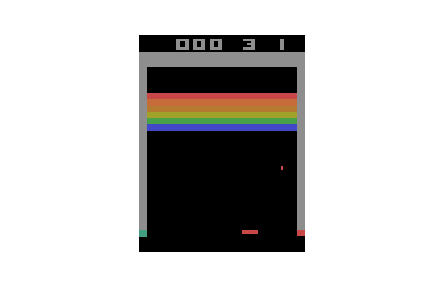
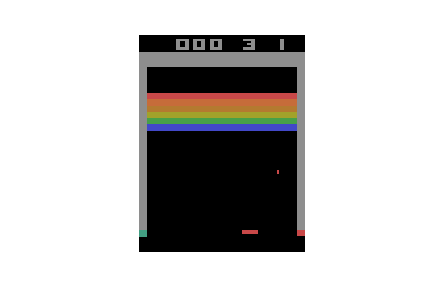
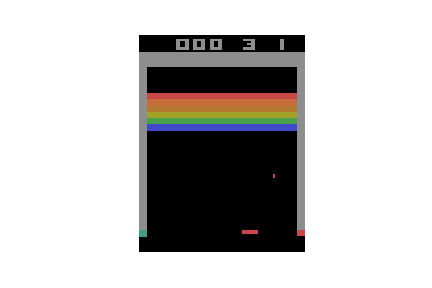
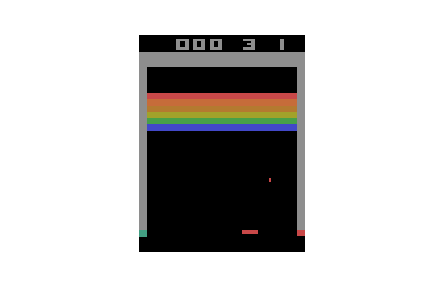
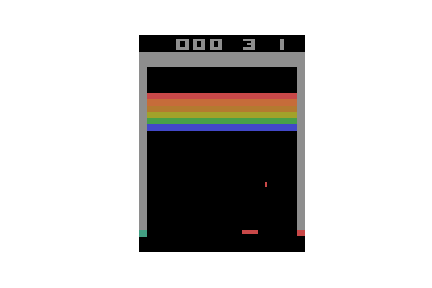
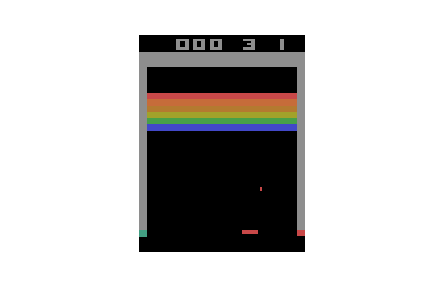
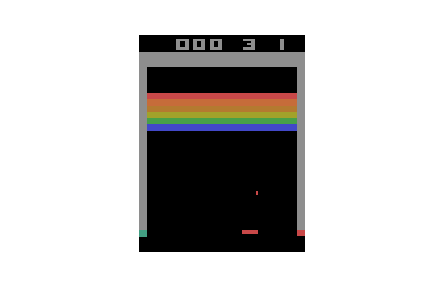
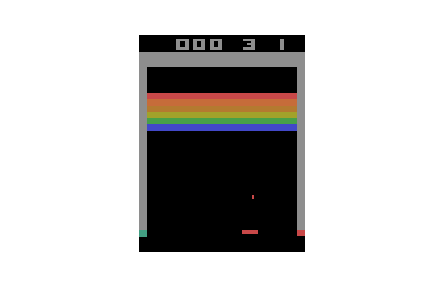
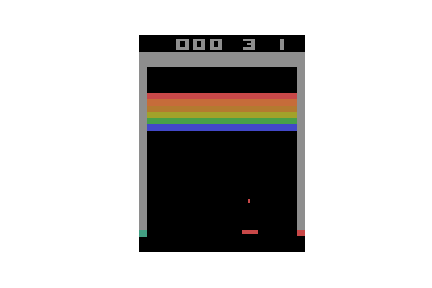
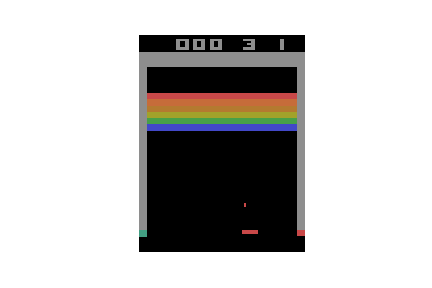
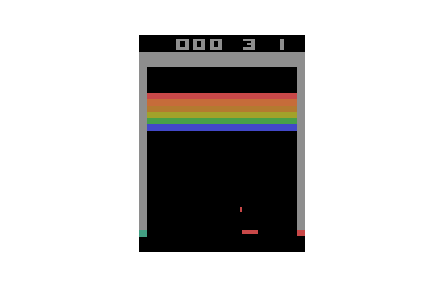
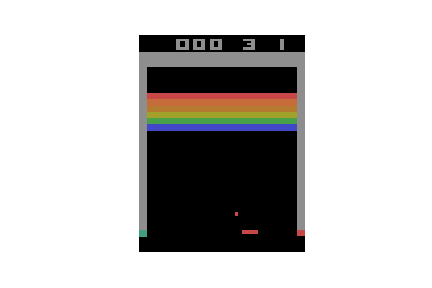
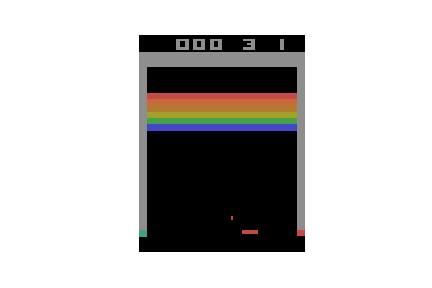
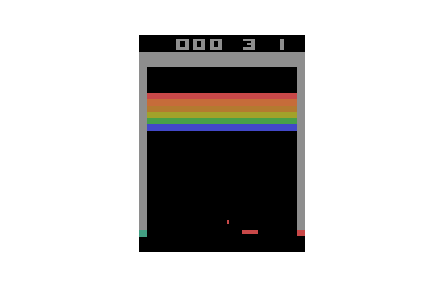
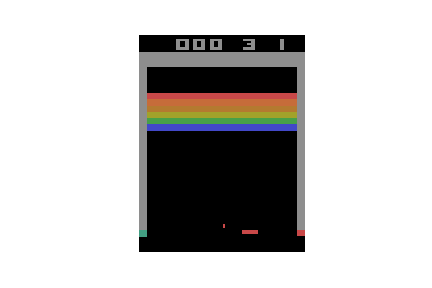
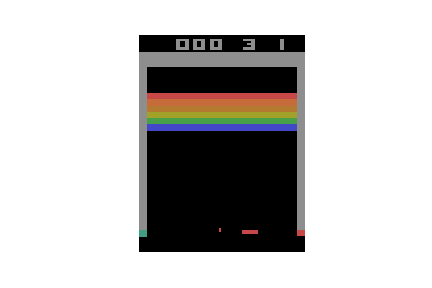
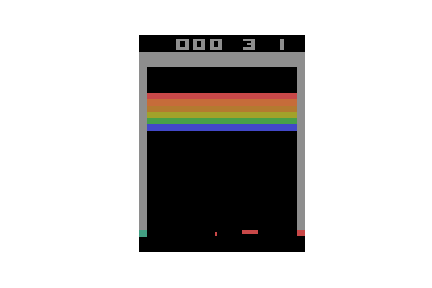
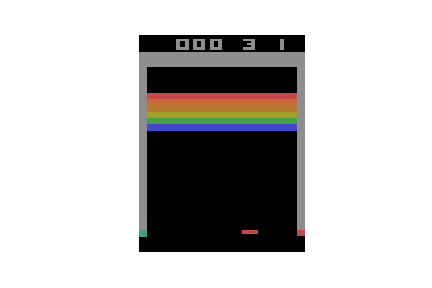
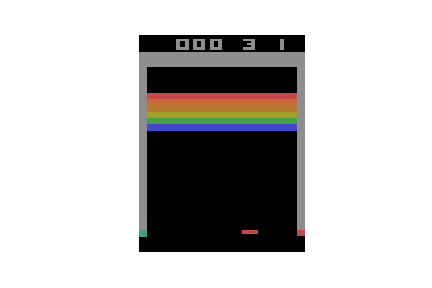
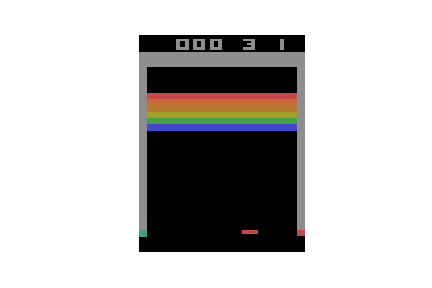
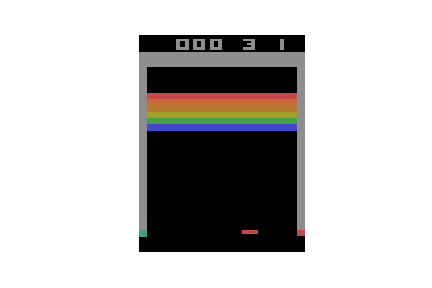
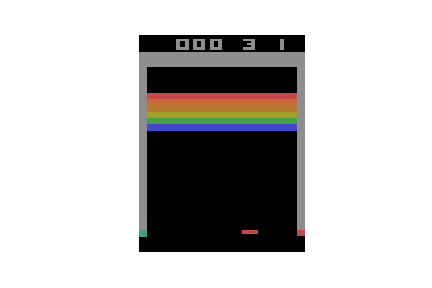
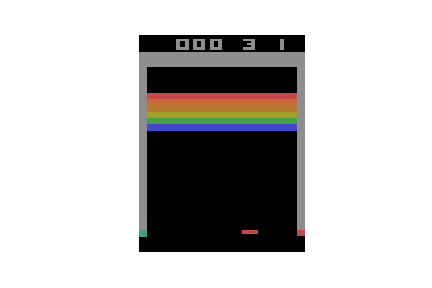
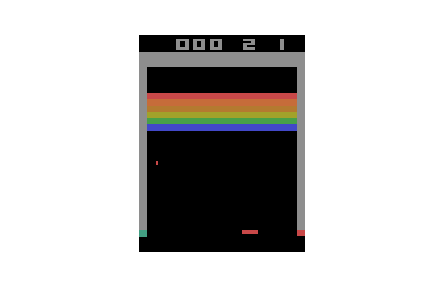
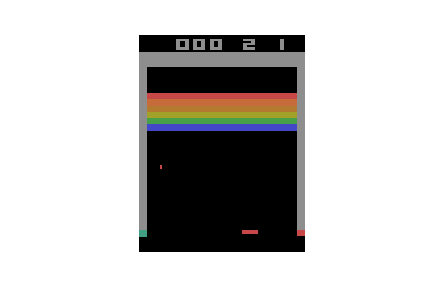
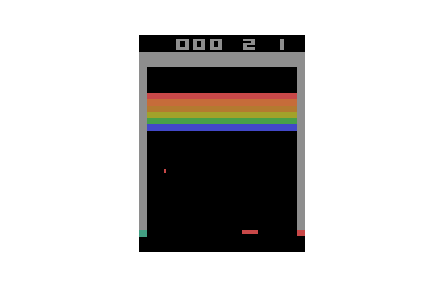
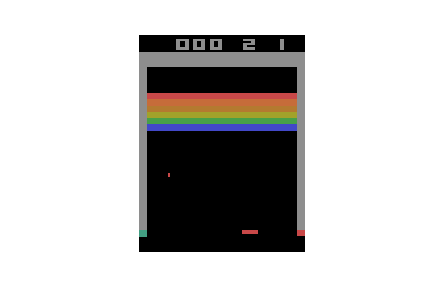
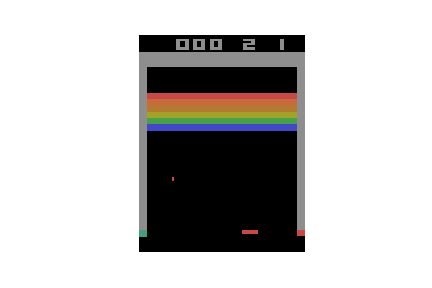
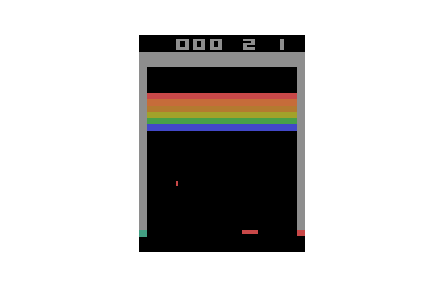
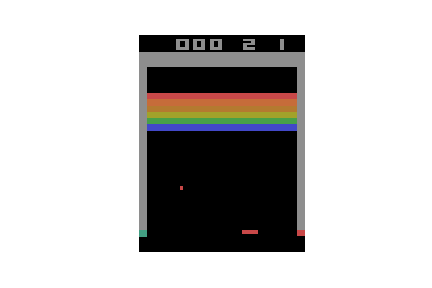
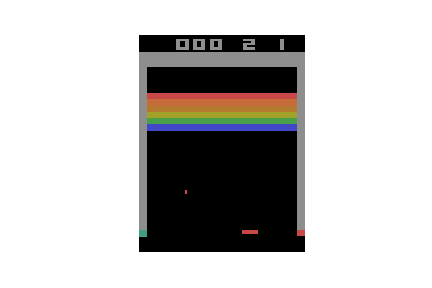
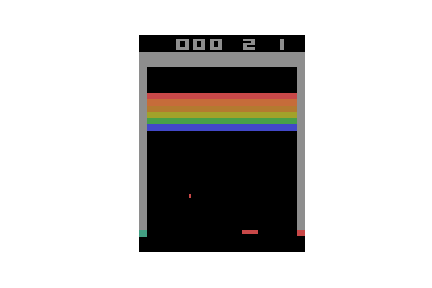
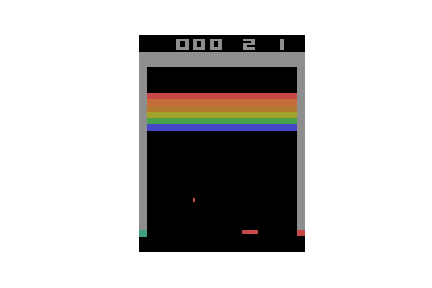
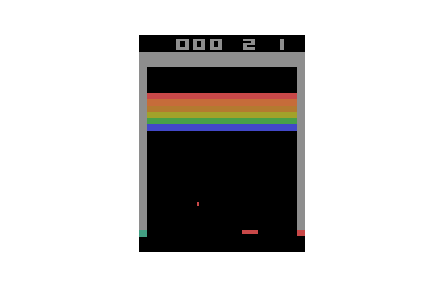
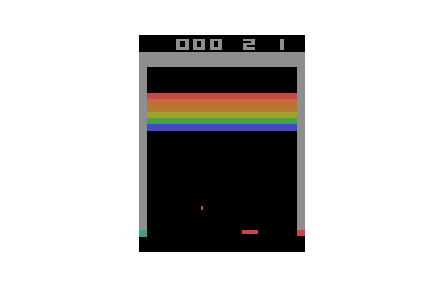
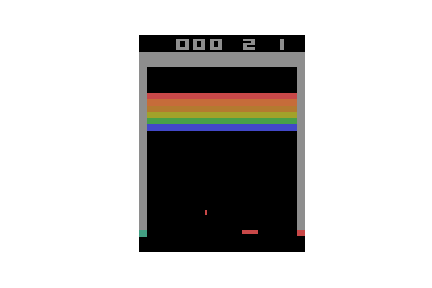
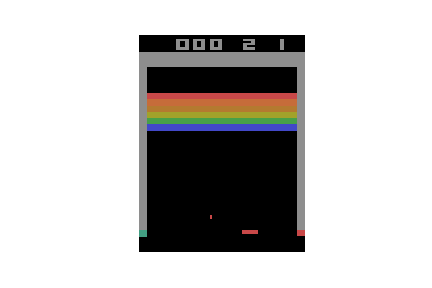
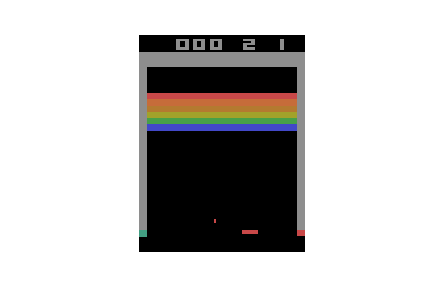
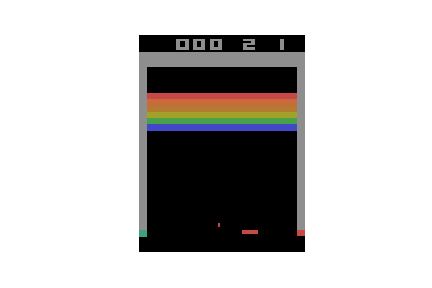
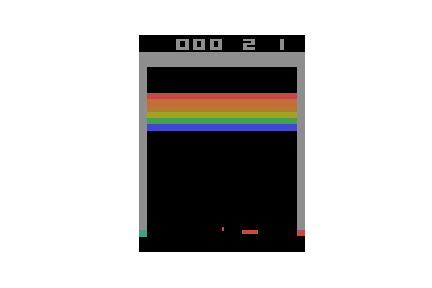
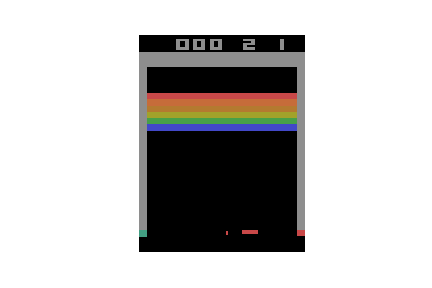
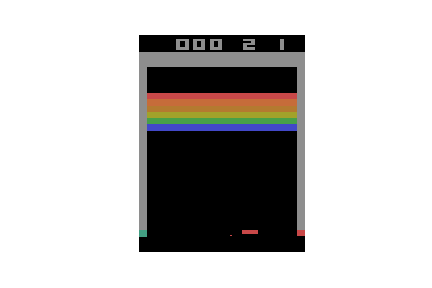
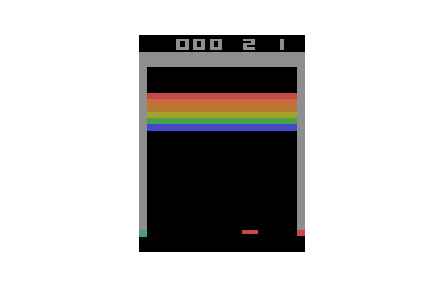
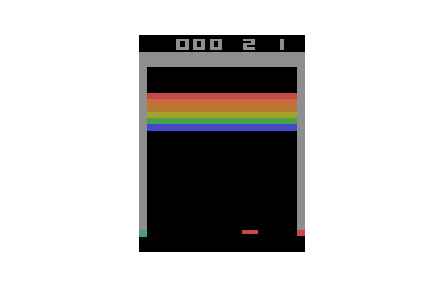
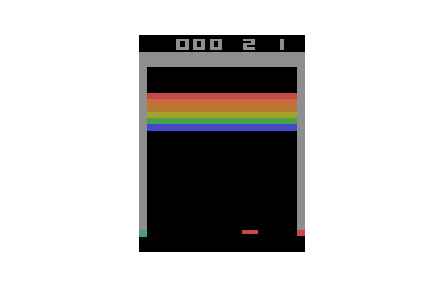
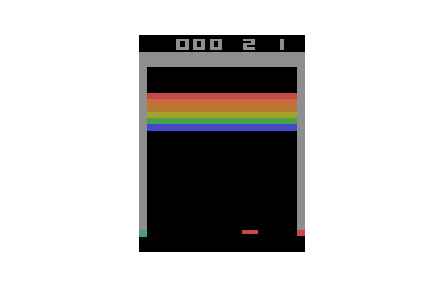
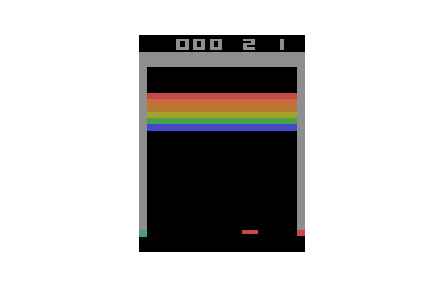
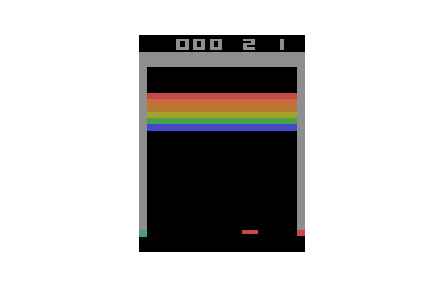
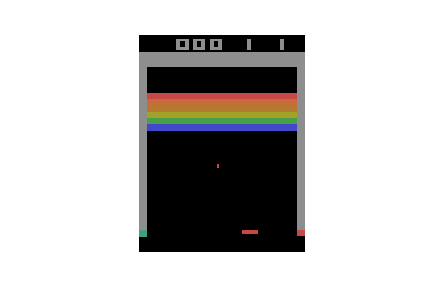
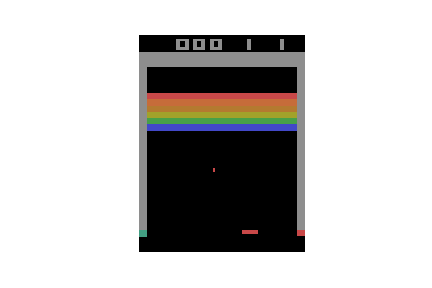
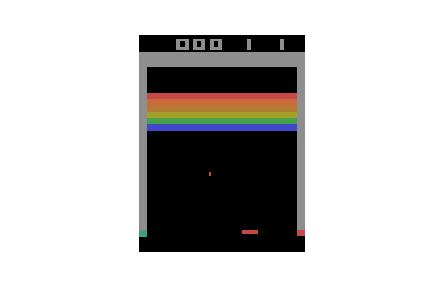
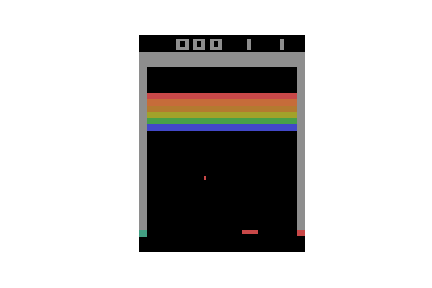
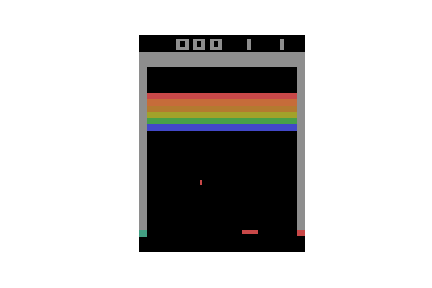
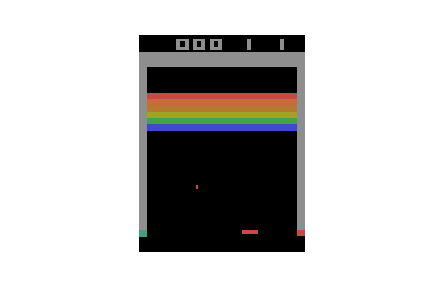
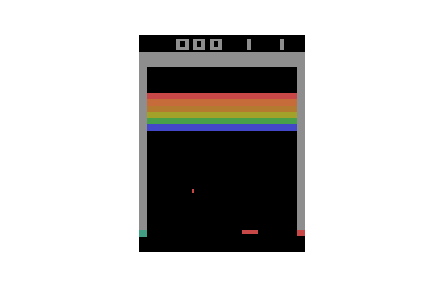
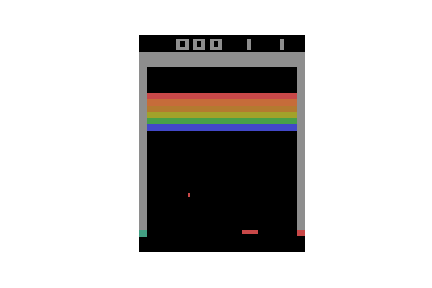
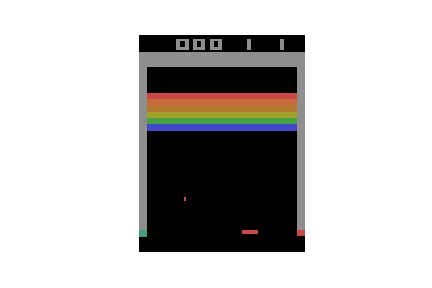
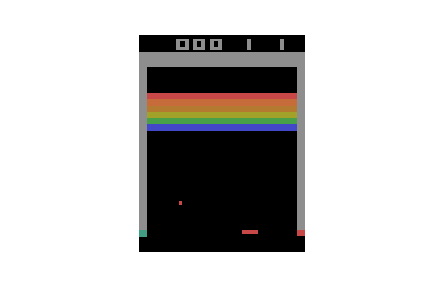
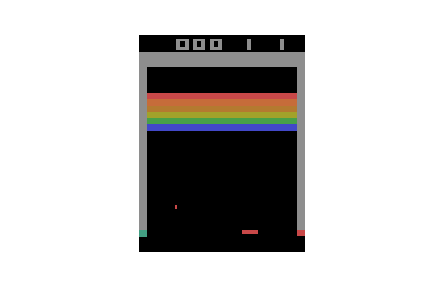
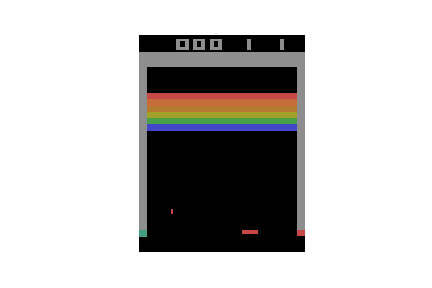
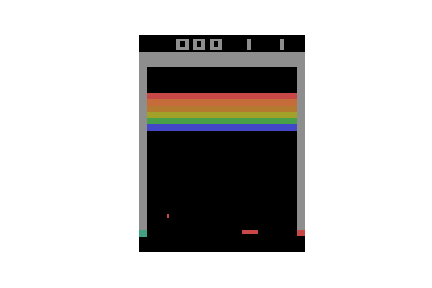
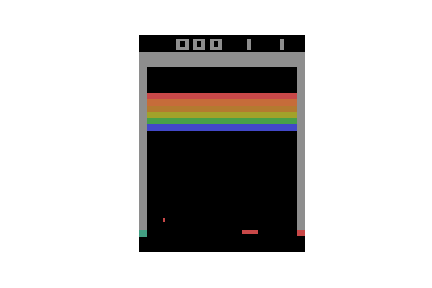
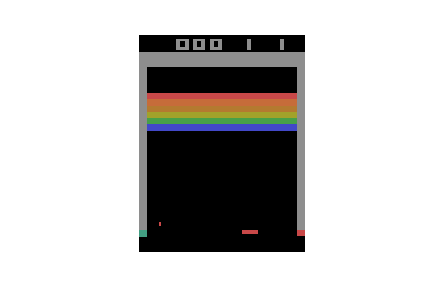
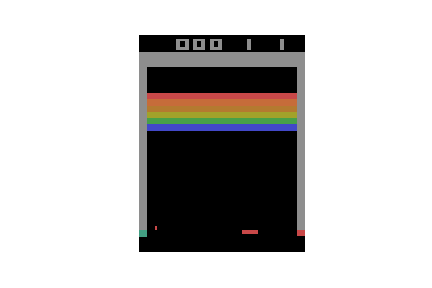
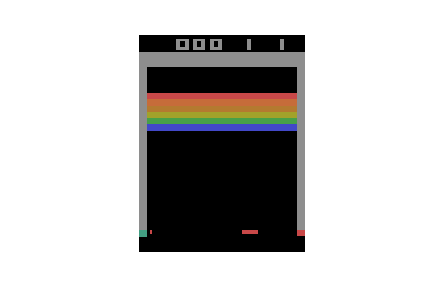
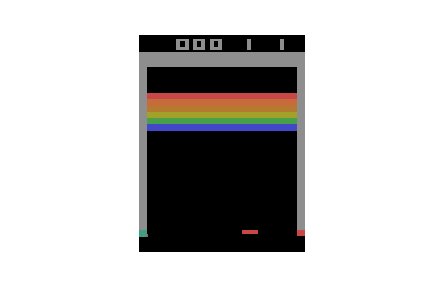
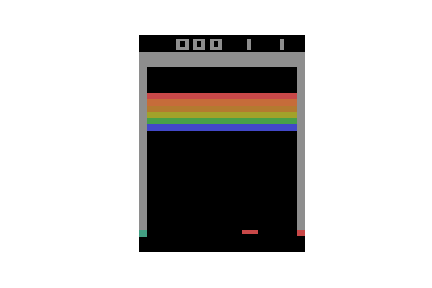
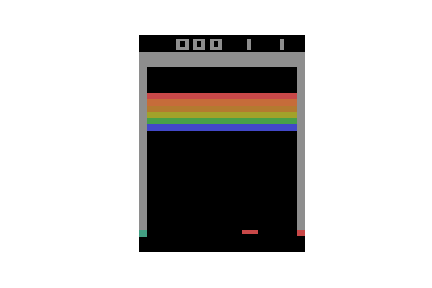
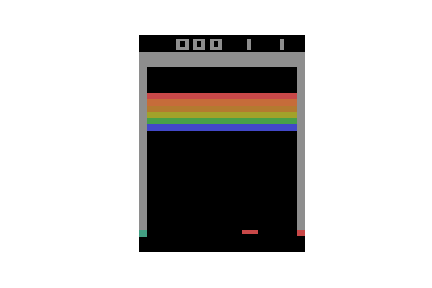
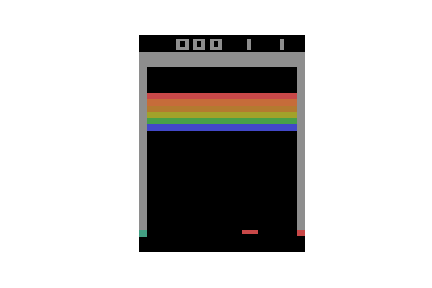
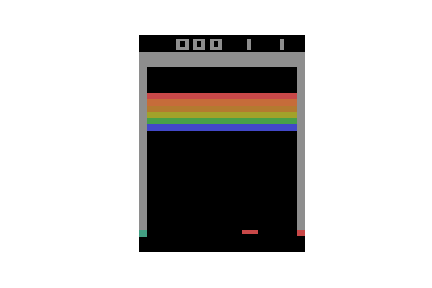
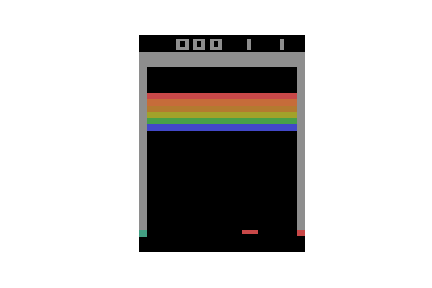
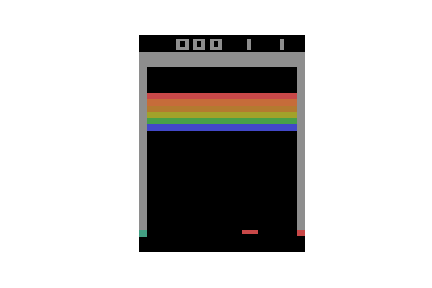

In [31]:

# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')
# Reset it, returns the starting frame
frames = []
frame = env.reset()

frame_buffer = init_state_buffer(4, preprocess(frame))

is_done = False
while not is_done:
    action = choose_best_action(0.0, model, frame_buffer)

    frame, reward, is_done, _ = env.step(action)
    # Render
    update_state_buffer(frame_buffer, preprocess(frame))
    frames.append(env.render(mode = 'rgb_array'))
env.close()
display_frames_as_gif(frames)
